# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from modules.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from modules.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Cleared previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [6]:
from modules.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from modules.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None
################################################################################

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=100, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        train_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

################################################################################

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.105694 val accuracy: 0.111000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.102449 val accuracy: 0.107000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.095510 val accuracy: 0.102000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.108714 val accuracy: 0.105000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.114224 val accuracy: 0.110000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.346082 val accuracy: 0.337000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.077796 val accuracy: 0.065000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.408163 val accuracy: 0.412000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.300980 val accuracy: 0.319000
best validation accuracy achieved during cross-validation: 0.412000


In [8]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.418


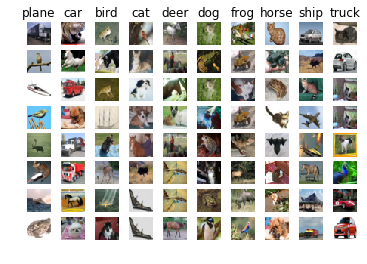

In [11]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=True)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [12]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


START...............
hyper-params sampling DONE..............
STARTING the TRAINING procedure............
hyper-params sampling DONE..............
STARTING the TRAINING procedure............
hyper-params sampling DONE..............
STARTING the TRAINING procedure............
hyper-params sampling DONE..............
STARTING the TRAINING procedure............
hyper-params sampling DONE..............
STARTING the TRAINING procedure............
iteration [0 / 1000] : loss = 130.459540
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = i

/media/potter217/Saililashah/Study/Projects/Project_ComputerVision/modules/classifiers/neural_net.py:102: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-1*np.log(scores_exp_norm[np.arange(N), y]))
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/media/potter217/Saililashah/Study/Projects/Project_ComputerVision/modules/classifiers/neural_net.py:104: RuntimeWarning: overflow encountered in multiply
  loss += reg * (np.sum(W1*W1) + np.sum(W2*W2))       # L2 regularization
/media/potter217/Saililashah/Study/Projects/Project_ComputerVision/modules/classifiers/neural_net.py:123: RuntimeWarning: invalid value encountered in greater
  mask_ReLU = scores_h1 > 0


iteration [23 / 1000] : loss = nan
iteration [24 / 1000] : loss = nan
iteration [25 / 1000] : loss = nan
iteration [26 / 1000] : loss = nan
iteration [27 / 1000] : loss = nan
iteration [28 / 1000] : loss = nan
iteration [29 / 1000] : loss = nan
iteration [30 / 1000] : loss = nan
iteration [31 / 1000] : loss = nan
iteration [32 / 1000] : loss = nan
iteration [33 / 1000] : loss = nan
iteration [34 / 1000] : loss = nan
iteration [35 / 1000] : loss = nan
iteration [36 / 1000] : loss = nan
iteration [37 / 1000] : loss = nan
iteration [38 / 1000] : loss = nan
iteration [39 / 1000] : loss = nan
iteration [40 / 1000] : loss = nan
iteration [41 / 1000] : loss = nan
iteration [42 / 1000] : loss = nan
iteration [43 / 1000] : loss = nan
iteration [44 / 1000] : loss = nan
iteration [45 / 1000] : loss = nan
iteration [46 / 1000] : loss = nan
iteration [47 / 1000] : loss = nan
iteration [48 / 1000] : loss = nan
iteration [49 / 1000] : loss = nan
iteration [50 / 1000] : loss = nan
iteration [51 / 1000

iteration [283 / 1000] : loss = nan
iteration [284 / 1000] : loss = nan
iteration [285 / 1000] : loss = nan
iteration [286 / 1000] : loss = nan
iteration [287 / 1000] : loss = nan
iteration [288 / 1000] : loss = nan
iteration [289 / 1000] : loss = nan
iteration [290 / 1000] : loss = nan
iteration [291 / 1000] : loss = nan
iteration [292 / 1000] : loss = nan
iteration [293 / 1000] : loss = nan
iteration [294 / 1000] : loss = nan
iteration [295 / 1000] : loss = nan
iteration [296 / 1000] : loss = nan
iteration [297 / 1000] : loss = nan
iteration [298 / 1000] : loss = nan
iteration [299 / 1000] : loss = nan
iteration [300 / 1000] : loss = nan
iteration [301 / 1000] : loss = nan
iteration [302 / 1000] : loss = nan
iteration [303 / 1000] : loss = nan
iteration [304 / 1000] : loss = nan
iteration [305 / 1000] : loss = nan
iteration [306 / 1000] : loss = nan
iteration [307 / 1000] : loss = nan
iteration [308 / 1000] : loss = nan
iteration [309 / 1000] : loss = nan
iteration [310 / 1000] : los

iteration [542 / 1000] : loss = nan
iteration [543 / 1000] : loss = nan
iteration [544 / 1000] : loss = nan
iteration [545 / 1000] : loss = nan
iteration [546 / 1000] : loss = nan
iteration [547 / 1000] : loss = nan
iteration [548 / 1000] : loss = nan
iteration [549 / 1000] : loss = nan
iteration [550 / 1000] : loss = nan
iteration [551 / 1000] : loss = nan
iteration [552 / 1000] : loss = nan
iteration [553 / 1000] : loss = nan
iteration [554 / 1000] : loss = nan
iteration [555 / 1000] : loss = nan
iteration [556 / 1000] : loss = nan
iteration [557 / 1000] : loss = nan
iteration [558 / 1000] : loss = nan
iteration [559 / 1000] : loss = nan
iteration [560 / 1000] : loss = nan
iteration [561 / 1000] : loss = nan
iteration [562 / 1000] : loss = nan
iteration [563 / 1000] : loss = nan
iteration [564 / 1000] : loss = nan
iteration [565 / 1000] : loss = nan
iteration [566 / 1000] : loss = nan
iteration [567 / 1000] : loss = nan
iteration [568 / 1000] : loss = nan
iteration [569 / 1000] : los

iteration [780 / 1000] : loss = nan
iteration [781 / 1000] : loss = nan
iteration [782 / 1000] : loss = nan
iteration [783 / 1000] : loss = nan
iteration [784 / 1000] : loss = nan
iteration [785 / 1000] : loss = nan
iteration [786 / 1000] : loss = nan
iteration [787 / 1000] : loss = nan
iteration [788 / 1000] : loss = nan
iteration [789 / 1000] : loss = nan
iteration [790 / 1000] : loss = nan
iteration [791 / 1000] : loss = nan
iteration [792 / 1000] : loss = nan
iteration [793 / 1000] : loss = nan
iteration [794 / 1000] : loss = nan
iteration [795 / 1000] : loss = nan
iteration [796 / 1000] : loss = nan
iteration [797 / 1000] : loss = nan
iteration [798 / 1000] : loss = nan
iteration [799 / 1000] : loss = nan
iteration [800 / 1000] : loss = nan
iteration [801 / 1000] : loss = nan
iteration [802 / 1000] : loss = nan
iteration [803 / 1000] : loss = nan
iteration [804 / 1000] : loss = nan
iteration [805 / 1000] : loss = nan
iteration [806 / 1000] : loss = nan
iteration [807 / 1000] : los

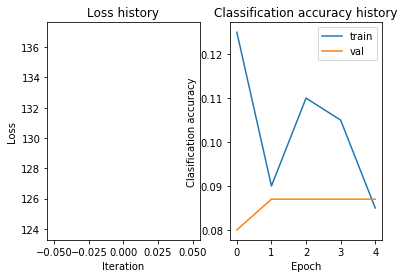

iteration [0 / 1000] : loss = 2.303143
iteration [1 / 1000] : loss = 26.275179
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 / 100

/media/potter217/Saililashah/Study/Projects/Project_ComputerVision/modules/classifiers/neural_net.py:97: RuntimeWarning: overflow encountered in subtract
  scores -= np.transpose([np.max(scores, axis=1)])    # normalization trick to prevent exponentiation boom
/media/potter217/Saililashah/Study/Projects/Project_ComputerVision/modules/classifiers/neural_net.py:97: RuntimeWarning: invalid value encountered in subtract
  scores -= np.transpose([np.max(scores, axis=1)])    # normalization trick to prevent exponentiation boom
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


iteration [75 / 1000] : loss = nan
iteration [76 / 1000] : loss = nan
iteration [77 / 1000] : loss = nan
iteration [78 / 1000] : loss = nan
iteration [79 / 1000] : loss = nan
iteration [80 / 1000] : loss = nan
iteration [81 / 1000] : loss = nan
iteration [82 / 1000] : loss = nan
iteration [83 / 1000] : loss = nan
iteration [84 / 1000] : loss = nan
iteration [85 / 1000] : loss = nan
iteration [86 / 1000] : loss = nan
iteration [87 / 1000] : loss = nan
iteration [88 / 1000] : loss = nan
iteration [89 / 1000] : loss = nan
iteration [90 / 1000] : loss = nan
iteration [91 / 1000] : loss = nan
iteration [92 / 1000] : loss = nan
iteration [93 / 1000] : loss = nan
iteration [94 / 1000] : loss = nan
iteration [95 / 1000] : loss = nan
iteration [96 / 1000] : loss = nan
iteration [97 / 1000] : loss = nan
iteration [98 / 1000] : loss = nan
iteration [99 / 1000] : loss = nan
iteration [100 / 1000] : loss = nan
iteration [101 / 1000] : loss = nan
iteration [102 / 1000] : loss = nan
iteration [103 / 

iteration [304 / 1000] : loss = nan
iteration [305 / 1000] : loss = nan
iteration [306 / 1000] : loss = nan
iteration [307 / 1000] : loss = nan
iteration [308 / 1000] : loss = nan
iteration [309 / 1000] : loss = nan
iteration [310 / 1000] : loss = nan
iteration [311 / 1000] : loss = nan
iteration [312 / 1000] : loss = nan
iteration [313 / 1000] : loss = nan
iteration [314 / 1000] : loss = nan
iteration [315 / 1000] : loss = nan
iteration [316 / 1000] : loss = nan
iteration [317 / 1000] : loss = nan
iteration [318 / 1000] : loss = nan
iteration [319 / 1000] : loss = nan
iteration [320 / 1000] : loss = nan
iteration [321 / 1000] : loss = nan
iteration [322 / 1000] : loss = nan
iteration [323 / 1000] : loss = nan
iteration [324 / 1000] : loss = nan
iteration [325 / 1000] : loss = nan
iteration [326 / 1000] : loss = nan
iteration [327 / 1000] : loss = nan
iteration [328 / 1000] : loss = nan
iteration [329 / 1000] : loss = nan
iteration [330 / 1000] : loss = nan
iteration [331 / 1000] : los

iteration [535 / 1000] : loss = nan
iteration [536 / 1000] : loss = nan
iteration [537 / 1000] : loss = nan
iteration [538 / 1000] : loss = nan
iteration [539 / 1000] : loss = nan
iteration [540 / 1000] : loss = nan
iteration [541 / 1000] : loss = nan
iteration [542 / 1000] : loss = nan
iteration [543 / 1000] : loss = nan
iteration [544 / 1000] : loss = nan
iteration [545 / 1000] : loss = nan
iteration [546 / 1000] : loss = nan
iteration [547 / 1000] : loss = nan
iteration [548 / 1000] : loss = nan
iteration [549 / 1000] : loss = nan
iteration [550 / 1000] : loss = nan
iteration [551 / 1000] : loss = nan
iteration [552 / 1000] : loss = nan
iteration [553 / 1000] : loss = nan
iteration [554 / 1000] : loss = nan
iteration [555 / 1000] : loss = nan
iteration [556 / 1000] : loss = nan
iteration [557 / 1000] : loss = nan
iteration [558 / 1000] : loss = nan
iteration [559 / 1000] : loss = nan
iteration [560 / 1000] : loss = nan
iteration [561 / 1000] : loss = nan
iteration [562 / 1000] : los

iteration [778 / 1000] : loss = nan
iteration [779 / 1000] : loss = nan
iteration [780 / 1000] : loss = nan
iteration [781 / 1000] : loss = nan
iteration [782 / 1000] : loss = nan
iteration [783 / 1000] : loss = nan
iteration [784 / 1000] : loss = nan
iteration [785 / 1000] : loss = nan
iteration [786 / 1000] : loss = nan
iteration [787 / 1000] : loss = nan
iteration [788 / 1000] : loss = nan
iteration [789 / 1000] : loss = nan
iteration [790 / 1000] : loss = nan
iteration [791 / 1000] : loss = nan
iteration [792 / 1000] : loss = nan
iteration [793 / 1000] : loss = nan
iteration [794 / 1000] : loss = nan
iteration [795 / 1000] : loss = nan
iteration [796 / 1000] : loss = nan
iteration [797 / 1000] : loss = nan
iteration [798 / 1000] : loss = nan
iteration [799 / 1000] : loss = nan
iteration [800 / 1000] : loss = nan
iteration [801 / 1000] : loss = nan
iteration [802 / 1000] : loss = nan
iteration [803 / 1000] : loss = nan
iteration [804 / 1000] : loss = nan
iteration [805 / 1000] : los

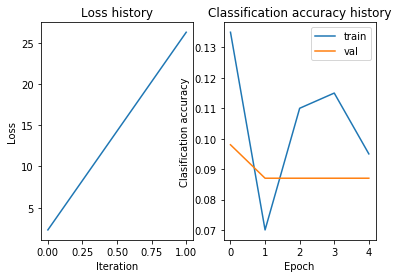

iteration [0 / 1000] : loss = 195.796623
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = nan
iteration [22 / 1000] : loss = nan
iteration [23 / 1000] : loss = nan
iteration [24 / 1000] : loss = nan
iteration [25 / 1000] : loss = nan
iteration [26 / 1000] : loss = nan
iteration [27 / 1000] : loss = nan
iteration [28 / 1000] :

iteration [231 / 1000] : loss = nan
iteration [232 / 1000] : loss = nan
iteration [233 / 1000] : loss = nan
iteration [234 / 1000] : loss = nan
iteration [235 / 1000] : loss = nan
iteration [236 / 1000] : loss = nan
iteration [237 / 1000] : loss = nan
iteration [238 / 1000] : loss = nan
iteration [239 / 1000] : loss = nan
iteration [240 / 1000] : loss = nan
iteration [241 / 1000] : loss = nan
iteration [242 / 1000] : loss = nan
iteration [243 / 1000] : loss = nan
iteration [244 / 1000] : loss = nan
iteration [245 / 1000] : loss = nan
iteration [246 / 1000] : loss = nan
iteration [247 / 1000] : loss = nan
iteration [248 / 1000] : loss = nan
iteration [249 / 1000] : loss = nan
iteration [250 / 1000] : loss = nan
iteration [251 / 1000] : loss = nan
iteration [252 / 1000] : loss = nan
iteration [253 / 1000] : loss = nan
iteration [254 / 1000] : loss = nan
iteration [255 / 1000] : loss = nan
iteration [256 / 1000] : loss = nan
iteration [257 / 1000] : loss = nan
iteration [258 / 1000] : los

iteration [469 / 1000] : loss = nan
iteration [470 / 1000] : loss = nan
iteration [471 / 1000] : loss = nan
iteration [472 / 1000] : loss = nan
iteration [473 / 1000] : loss = nan
iteration [474 / 1000] : loss = nan
iteration [475 / 1000] : loss = nan
iteration [476 / 1000] : loss = nan
iteration [477 / 1000] : loss = nan
iteration [478 / 1000] : loss = nan
iteration [479 / 1000] : loss = nan
iteration [480 / 1000] : loss = nan
iteration [481 / 1000] : loss = nan
iteration [482 / 1000] : loss = nan
iteration [483 / 1000] : loss = nan
iteration [484 / 1000] : loss = nan
iteration [485 / 1000] : loss = nan
iteration [486 / 1000] : loss = nan
iteration [487 / 1000] : loss = nan
iteration [488 / 1000] : loss = nan
iteration [489 / 1000] : loss = nan
iteration [490 / 1000] : loss = nan
iteration [491 / 1000] : loss = nan
iteration [492 / 1000] : loss = nan
iteration [493 / 1000] : loss = nan
iteration [494 / 1000] : loss = nan
iteration [495 / 1000] : loss = nan
iteration [496 / 1000] : los

iteration [710 / 1000] : loss = nan
iteration [711 / 1000] : loss = nan
iteration [712 / 1000] : loss = nan
iteration [713 / 1000] : loss = nan
iteration [714 / 1000] : loss = nan
iteration [715 / 1000] : loss = nan
iteration [716 / 1000] : loss = nan
iteration [717 / 1000] : loss = nan
iteration [718 / 1000] : loss = nan
iteration [719 / 1000] : loss = nan
iteration [720 / 1000] : loss = nan
iteration [721 / 1000] : loss = nan
iteration [722 / 1000] : loss = nan
iteration [723 / 1000] : loss = nan
iteration [724 / 1000] : loss = nan
iteration [725 / 1000] : loss = nan
iteration [726 / 1000] : loss = nan
iteration [727 / 1000] : loss = nan
iteration [728 / 1000] : loss = nan
iteration [729 / 1000] : loss = nan
iteration [730 / 1000] : loss = nan
iteration [731 / 1000] : loss = nan
iteration [732 / 1000] : loss = nan
iteration [733 / 1000] : loss = nan
iteration [734 / 1000] : loss = nan
iteration [735 / 1000] : loss = nan
iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : los

iteration [951 / 1000] : loss = nan
iteration [952 / 1000] : loss = nan
iteration [953 / 1000] : loss = nan
iteration [954 / 1000] : loss = nan
iteration [955 / 1000] : loss = nan
iteration [956 / 1000] : loss = nan
iteration [957 / 1000] : loss = nan
iteration [958 / 1000] : loss = nan
iteration [959 / 1000] : loss = nan
iteration [960 / 1000] : loss = nan
iteration [961 / 1000] : loss = nan
iteration [962 / 1000] : loss = nan
iteration [963 / 1000] : loss = nan
iteration [964 / 1000] : loss = nan
iteration [965 / 1000] : loss = nan
iteration [966 / 1000] : loss = nan
iteration [967 / 1000] : loss = nan
iteration [968 / 1000] : loss = nan
iteration [969 / 1000] : loss = nan
iteration [970 / 1000] : loss = nan
iteration [971 / 1000] : loss = nan
iteration [972 / 1000] : loss = nan
iteration [973 / 1000] : loss = nan
iteration [974 / 1000] : loss = nan
iteration [975 / 1000] : loss = nan
iteration [976 / 1000] : loss = nan
iteration [977 / 1000] : loss = nan
iteration [978 / 1000] : los

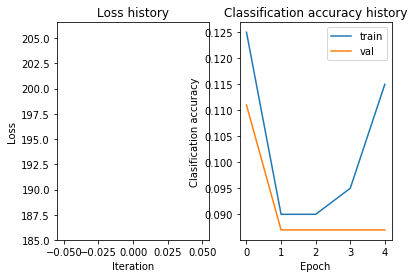

iteration [0 / 1000] : loss = 3.085000
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 / 1000] : l

iteration [267 / 1000] : loss = nan
iteration [268 / 1000] : loss = nan
iteration [269 / 1000] : loss = nan
iteration [270 / 1000] : loss = nan
iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : loss = nan
iteration [280 / 1000] : loss = nan
iteration [281 / 1000] : loss = nan
iteration [282 / 1000] : loss = nan
iteration [283 / 1000] : loss = nan
iteration [284 / 1000] : loss = nan
iteration [285 / 1000] : loss = nan
iteration [286 / 1000] : loss = nan
iteration [287 / 1000] : loss = nan
iteration [288 / 1000] : loss = nan
iteration [289 / 1000] : loss = nan
iteration [290 / 1000] : loss = nan
iteration [291 / 1000] : loss = nan
iteration [292 / 1000] : loss = nan
iteration [293 / 1000] : loss = nan
iteration [294 / 1000] : los

iteration [504 / 1000] : loss = nan
iteration [505 / 1000] : loss = nan
iteration [506 / 1000] : loss = nan
iteration [507 / 1000] : loss = nan
iteration [508 / 1000] : loss = nan
iteration [509 / 1000] : loss = nan
iteration [510 / 1000] : loss = nan
iteration [511 / 1000] : loss = nan
iteration [512 / 1000] : loss = nan
iteration [513 / 1000] : loss = nan
iteration [514 / 1000] : loss = nan
iteration [515 / 1000] : loss = nan
iteration [516 / 1000] : loss = nan
iteration [517 / 1000] : loss = nan
iteration [518 / 1000] : loss = nan
iteration [519 / 1000] : loss = nan
iteration [520 / 1000] : loss = nan
iteration [521 / 1000] : loss = nan
iteration [522 / 1000] : loss = nan
iteration [523 / 1000] : loss = nan
iteration [524 / 1000] : loss = nan
iteration [525 / 1000] : loss = nan
iteration [526 / 1000] : loss = nan
iteration [527 / 1000] : loss = nan
iteration [528 / 1000] : loss = nan
iteration [529 / 1000] : loss = nan
iteration [530 / 1000] : loss = nan
iteration [531 / 1000] : los

iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : loss = nan
iteration [749 / 1000] : loss = nan
iteration [750 / 1000] : loss = nan
iteration [751 / 1000] : loss = nan
iteration [752 / 1000] : loss = nan
iteration [753 / 1000] : loss = nan
iteration [754 / 1000] : loss = nan
iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : loss = nan
iteration [759 / 1000] : loss = nan
iteration [760 / 1000] : loss = nan
iteration [761 / 1000] : loss = nan
iteration [762 / 1000] : loss = nan
iteration [763 / 1000] : los

iteration [966 / 1000] : loss = nan
iteration [967 / 1000] : loss = nan
iteration [968 / 1000] : loss = nan
iteration [969 / 1000] : loss = nan
iteration [970 / 1000] : loss = nan
iteration [971 / 1000] : loss = nan
iteration [972 / 1000] : loss = nan
iteration [973 / 1000] : loss = nan
iteration [974 / 1000] : loss = nan
iteration [975 / 1000] : loss = nan
iteration [976 / 1000] : loss = nan
iteration [977 / 1000] : loss = nan
iteration [978 / 1000] : loss = nan
iteration [979 / 1000] : loss = nan
iteration [980 / 1000] : loss = nan
iteration [981 / 1000] : loss = nan
iteration [982 / 1000] : loss = nan
iteration [983 / 1000] : loss = nan
iteration [984 / 1000] : loss = nan
iteration [985 / 1000] : loss = nan
iteration [986 / 1000] : loss = nan
iteration [987 / 1000] : loss = nan
iteration [988 / 1000] : loss = nan
iteration [989 / 1000] : loss = nan
iteration [990 / 1000] : loss = nan
iteration [991 / 1000] : loss = nan
iteration [992 / 1000] : loss = nan
iteration [993 / 1000] : los

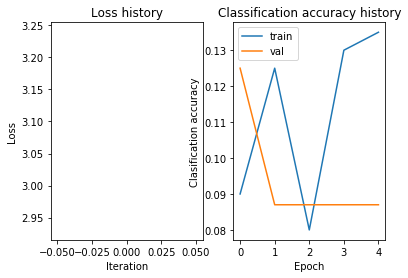

iteration [0 / 1000] : loss = 2.413634
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 / 1000] : l

/media/potter217/Saililashah/Study/Projects/Project_ComputerVision/modules/classifiers/neural_net.py:104: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * (np.sum(W1*W1) + np.sum(W2*W2))       # L2 regularization


iteration [72 / 1000] : loss = nan
iteration [73 / 1000] : loss = nan
iteration [74 / 1000] : loss = nan
iteration [75 / 1000] : loss = nan
iteration [76 / 1000] : loss = nan
iteration [77 / 1000] : loss = nan
iteration [78 / 1000] : loss = nan
iteration [79 / 1000] : loss = nan
iteration [80 / 1000] : loss = nan
iteration [81 / 1000] : loss = nan
iteration [82 / 1000] : loss = nan
iteration [83 / 1000] : loss = nan
iteration [84 / 1000] : loss = nan
iteration [85 / 1000] : loss = nan
iteration [86 / 1000] : loss = nan
iteration [87 / 1000] : loss = nan
iteration [88 / 1000] : loss = nan
iteration [89 / 1000] : loss = nan
iteration [90 / 1000] : loss = nan
iteration [91 / 1000] : loss = nan
iteration [92 / 1000] : loss = nan
iteration [93 / 1000] : loss = nan
iteration [94 / 1000] : loss = nan
iteration [95 / 1000] : loss = nan
iteration [96 / 1000] : loss = nan
iteration [97 / 1000] : loss = nan
iteration [98 / 1000] : loss = nan
iteration [99 / 1000] : loss = nan
iteration [100 / 100

iteration [330 / 1000] : loss = nan
iteration [331 / 1000] : loss = nan
iteration [332 / 1000] : loss = nan
iteration [333 / 1000] : loss = nan
iteration [334 / 1000] : loss = nan
iteration [335 / 1000] : loss = nan
iteration [336 / 1000] : loss = nan
iteration [337 / 1000] : loss = nan
iteration [338 / 1000] : loss = nan
iteration [339 / 1000] : loss = nan
iteration [340 / 1000] : loss = nan
iteration [341 / 1000] : loss = nan
iteration [342 / 1000] : loss = nan
iteration [343 / 1000] : loss = nan
iteration [344 / 1000] : loss = nan
iteration [345 / 1000] : loss = nan
iteration [346 / 1000] : loss = nan
iteration [347 / 1000] : loss = nan
iteration [348 / 1000] : loss = nan
iteration [349 / 1000] : loss = nan
iteration [350 / 1000] : loss = nan
iteration [351 / 1000] : loss = nan
iteration [352 / 1000] : loss = nan
iteration [353 / 1000] : loss = nan
iteration [354 / 1000] : loss = nan
iteration [355 / 1000] : loss = nan
iteration [356 / 1000] : loss = nan
iteration [357 / 1000] : los

iteration [597 / 1000] : loss = nan
iteration [598 / 1000] : loss = nan
iteration [599 / 1000] : loss = nan
iteration [600 / 1000] : loss = nan
iteration [601 / 1000] : loss = nan
iteration [602 / 1000] : loss = nan
iteration [603 / 1000] : loss = nan
iteration [604 / 1000] : loss = nan
iteration [605 / 1000] : loss = nan
iteration [606 / 1000] : loss = nan
iteration [607 / 1000] : loss = nan
iteration [608 / 1000] : loss = nan
iteration [609 / 1000] : loss = nan
iteration [610 / 1000] : loss = nan
iteration [611 / 1000] : loss = nan
iteration [612 / 1000] : loss = nan
iteration [613 / 1000] : loss = nan
iteration [614 / 1000] : loss = nan
iteration [615 / 1000] : loss = nan
iteration [616 / 1000] : loss = nan
iteration [617 / 1000] : loss = nan
iteration [618 / 1000] : loss = nan
iteration [619 / 1000] : loss = nan
iteration [620 / 1000] : loss = nan
iteration [621 / 1000] : loss = nan
iteration [622 / 1000] : loss = nan
iteration [623 / 1000] : loss = nan
iteration [624 / 1000] : los

iteration [863 / 1000] : loss = nan
iteration [864 / 1000] : loss = nan
iteration [865 / 1000] : loss = nan
iteration [866 / 1000] : loss = nan
iteration [867 / 1000] : loss = nan
iteration [868 / 1000] : loss = nan
iteration [869 / 1000] : loss = nan
iteration [870 / 1000] : loss = nan
iteration [871 / 1000] : loss = nan
iteration [872 / 1000] : loss = nan
iteration [873 / 1000] : loss = nan
iteration [874 / 1000] : loss = nan
iteration [875 / 1000] : loss = nan
iteration [876 / 1000] : loss = nan
iteration [877 / 1000] : loss = nan
iteration [878 / 1000] : loss = nan
iteration [879 / 1000] : loss = nan
iteration [880 / 1000] : loss = nan
iteration [881 / 1000] : loss = nan
iteration [882 / 1000] : loss = nan
iteration [883 / 1000] : loss = nan
iteration [884 / 1000] : loss = nan
iteration [885 / 1000] : loss = nan
iteration [886 / 1000] : loss = nan
iteration [887 / 1000] : loss = nan
iteration [888 / 1000] : loss = nan
iteration [889 / 1000] : loss = nan
iteration [890 / 1000] : los

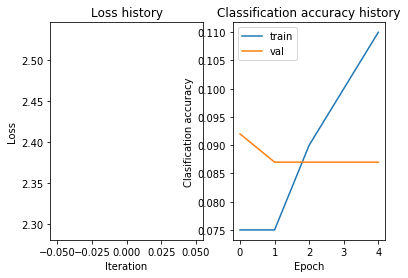

iteration [0 / 1000] : loss = 128.322462
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 / 1000] :

iteration [240 / 1000] : loss = nan
iteration [241 / 1000] : loss = nan
iteration [242 / 1000] : loss = nan
iteration [243 / 1000] : loss = nan
iteration [244 / 1000] : loss = nan
iteration [245 / 1000] : loss = nan
iteration [246 / 1000] : loss = nan
iteration [247 / 1000] : loss = nan
iteration [248 / 1000] : loss = nan
iteration [249 / 1000] : loss = nan
iteration [250 / 1000] : loss = nan
iteration [251 / 1000] : loss = nan
iteration [252 / 1000] : loss = nan
iteration [253 / 1000] : loss = nan
iteration [254 / 1000] : loss = nan
iteration [255 / 1000] : loss = nan
iteration [256 / 1000] : loss = nan
iteration [257 / 1000] : loss = nan
iteration [258 / 1000] : loss = nan
iteration [259 / 1000] : loss = nan
iteration [260 / 1000] : loss = nan
iteration [261 / 1000] : loss = nan
iteration [262 / 1000] : loss = nan
iteration [263 / 1000] : loss = nan
iteration [264 / 1000] : loss = nan
iteration [265 / 1000] : loss = nan
iteration [266 / 1000] : loss = nan
iteration [267 / 1000] : los

iteration [490 / 1000] : loss = nan
iteration [491 / 1000] : loss = nan
iteration [492 / 1000] : loss = nan
iteration [493 / 1000] : loss = nan
iteration [494 / 1000] : loss = nan
iteration [495 / 1000] : loss = nan
iteration [496 / 1000] : loss = nan
iteration [497 / 1000] : loss = nan
iteration [498 / 1000] : loss = nan
iteration [499 / 1000] : loss = nan
iteration [500 / 1000] : loss = nan
iteration [501 / 1000] : loss = nan
iteration [502 / 1000] : loss = nan
iteration [503 / 1000] : loss = nan
iteration [504 / 1000] : loss = nan
iteration [505 / 1000] : loss = nan
iteration [506 / 1000] : loss = nan
iteration [507 / 1000] : loss = nan
iteration [508 / 1000] : loss = nan
iteration [509 / 1000] : loss = nan
iteration [510 / 1000] : loss = nan
iteration [511 / 1000] : loss = nan
iteration [512 / 1000] : loss = nan
iteration [513 / 1000] : loss = nan
iteration [514 / 1000] : loss = nan
iteration [515 / 1000] : loss = nan
iteration [516 / 1000] : loss = nan
iteration [517 / 1000] : los

iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : loss = nan
iteration [749 / 1000] : loss = nan
iteration [750 / 1000] : loss = nan
iteration [751 / 1000] : loss = nan
iteration [752 / 1000] : loss = nan
iteration [753 / 1000] : loss = nan
iteration [754 / 1000] : loss = nan
iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : loss = nan
iteration [759 / 1000] : loss = nan
iteration [760 / 1000] : loss = nan
iteration [761 / 1000] : loss = nan
iteration [762 / 1000] : loss = nan
iteration [763 / 1000] : los

iteration [968 / 1000] : loss = nan
iteration [969 / 1000] : loss = nan
iteration [970 / 1000] : loss = nan
iteration [971 / 1000] : loss = nan
iteration [972 / 1000] : loss = nan
iteration [973 / 1000] : loss = nan
iteration [974 / 1000] : loss = nan
iteration [975 / 1000] : loss = nan
iteration [976 / 1000] : loss = nan
iteration [977 / 1000] : loss = nan
iteration [978 / 1000] : loss = nan
iteration [979 / 1000] : loss = nan
iteration [980 / 1000] : loss = nan
iteration [981 / 1000] : loss = nan
iteration [982 / 1000] : loss = nan
iteration [983 / 1000] : loss = nan
iteration [984 / 1000] : loss = nan
iteration [985 / 1000] : loss = nan
iteration [986 / 1000] : loss = nan
iteration [987 / 1000] : loss = nan
iteration [988 / 1000] : loss = nan
iteration [989 / 1000] : loss = nan
iteration [990 / 1000] : loss = nan
iteration [991 / 1000] : loss = nan
iteration [992 / 1000] : loss = nan
iteration [993 / 1000] : loss = nan
iteration [994 / 1000] : loss = nan
iteration [995 / 1000] : los

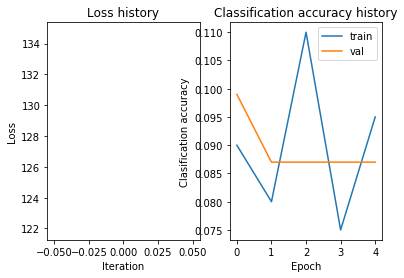

iteration [0 / 1000] : loss = 2.303144
iteration [1 / 1000] : loss = 2.302981
iteration [2 / 1000] : loss = 2.302990
iteration [3 / 1000] : loss = 2.302286
iteration [4 / 1000] : loss = 2.299584
iteration [5 / 1000] : loss = 2.306131
iteration [6 / 1000] : loss = 2.302654
iteration [7 / 1000] : loss = 2.302265
iteration [8 / 1000] : loss = 2.302319
iteration [9 / 1000] : loss = 2.301575
iteration [10 / 1000] : loss = 2.306158
iteration [11 / 1000] : loss = 2.303690
iteration [12 / 1000] : loss = 2.301649
iteration [13 / 1000] : loss = 2.302666
iteration [14 / 1000] : loss = 2.302220
iteration [15 / 1000] : loss = 2.302039
iteration [16 / 1000] : loss = 2.298632
iteration [17 / 1000] : loss = 2.308661
iteration [18 / 1000] : loss = 2.302715
iteration [19 / 1000] : loss = 2.300975
iteration [20 / 1000] : loss = 2.305082
iteration [21 / 1000] : loss = 2.304520
iteration [22 / 1000] : loss = 2.299334
iteration [23 / 1000] : loss = 2.302215
iteration [24 / 1000] : loss = 2.303367
iteration 

iteration [218 / 1000] : loss = 2.302528
iteration [219 / 1000] : loss = 2.301477
iteration [220 / 1000] : loss = 2.301913
iteration [221 / 1000] : loss = 2.310568
iteration [222 / 1000] : loss = 2.302741
iteration [223 / 1000] : loss = 2.301230
iteration [224 / 1000] : loss = 2.307112
iteration [225 / 1000] : loss = 2.301076
iteration [226 / 1000] : loss = 2.304002
iteration [227 / 1000] : loss = 2.304784
iteration [228 / 1000] : loss = 2.299084
iteration [229 / 1000] : loss = 2.304966
iteration [230 / 1000] : loss = 2.305426
iteration [231 / 1000] : loss = 2.308134
iteration [232 / 1000] : loss = 2.305483
iteration [233 / 1000] : loss = 2.302802
iteration [234 / 1000] : loss = 2.302490
iteration [235 / 1000] : loss = 2.302479
iteration [236 / 1000] : loss = 2.301476
iteration [237 / 1000] : loss = 2.301756
iteration [238 / 1000] : loss = 2.302482
iteration [239 / 1000] : loss = 2.304143
iteration [240 / 1000] : loss = 2.302853
iteration [241 / 1000] : loss = 2.302747
iteration [242 /

iteration [437 / 1000] : loss = 2.304517
iteration [438 / 1000] : loss = 2.306060
iteration [439 / 1000] : loss = 2.302054
iteration [440 / 1000] : loss = 2.304883
iteration [441 / 1000] : loss = 2.301116
iteration [442 / 1000] : loss = 2.307033
iteration [443 / 1000] : loss = 2.304852
iteration [444 / 1000] : loss = 2.302453
iteration [445 / 1000] : loss = 2.301326
iteration [446 / 1000] : loss = 2.302126
iteration [447 / 1000] : loss = 2.303669
iteration [448 / 1000] : loss = 2.302079
iteration [449 / 1000] : loss = 2.305153
iteration [450 / 1000] : loss = 2.304888
iteration [451 / 1000] : loss = 2.304795
iteration [452 / 1000] : loss = 2.304159
iteration [453 / 1000] : loss = 2.303738
iteration [454 / 1000] : loss = 2.302581
iteration [455 / 1000] : loss = 2.305846
iteration [456 / 1000] : loss = 2.302966
iteration [457 / 1000] : loss = 2.300949
iteration [458 / 1000] : loss = 2.304097
iteration [459 / 1000] : loss = 2.303819
iteration [460 / 1000] : loss = 2.304870
iteration [461 /

iteration [667 / 1000] : loss = 2.301223
iteration [668 / 1000] : loss = 2.303563
iteration [669 / 1000] : loss = 2.306779
iteration [670 / 1000] : loss = 2.308760
iteration [671 / 1000] : loss = 2.300084
iteration [672 / 1000] : loss = 2.307920
iteration [673 / 1000] : loss = 2.299601
iteration [674 / 1000] : loss = 2.300241
iteration [675 / 1000] : loss = 2.305333
iteration [676 / 1000] : loss = 2.302499
iteration [677 / 1000] : loss = 2.299537
iteration [678 / 1000] : loss = 2.307299
iteration [679 / 1000] : loss = 2.300454
iteration [680 / 1000] : loss = 2.303689
iteration [681 / 1000] : loss = 2.306540
iteration [682 / 1000] : loss = 2.303912
iteration [683 / 1000] : loss = 2.303620
iteration [684 / 1000] : loss = 2.304702
iteration [685 / 1000] : loss = 2.299056
iteration [686 / 1000] : loss = 2.301301
iteration [687 / 1000] : loss = 2.302741
iteration [688 / 1000] : loss = 2.297865
iteration [689 / 1000] : loss = 2.306114
iteration [690 / 1000] : loss = 2.302989
iteration [691 /

iteration [868 / 1000] : loss = 2.306082
iteration [869 / 1000] : loss = 2.302400
iteration [870 / 1000] : loss = 2.303935
iteration [871 / 1000] : loss = 2.299246
iteration [872 / 1000] : loss = 2.304400
iteration [873 / 1000] : loss = 2.298553
iteration [874 / 1000] : loss = 2.306408
iteration [875 / 1000] : loss = 2.307258
iteration [876 / 1000] : loss = 2.297645
iteration [877 / 1000] : loss = 2.306817
iteration [878 / 1000] : loss = 2.301791
iteration [879 / 1000] : loss = 2.304018
iteration [880 / 1000] : loss = 2.303117
iteration [881 / 1000] : loss = 2.300548
iteration [882 / 1000] : loss = 2.304533
iteration [883 / 1000] : loss = 2.305205
iteration [884 / 1000] : loss = 2.303567
iteration [885 / 1000] : loss = 2.307044
iteration [886 / 1000] : loss = 2.303161
iteration [887 / 1000] : loss = 2.301461
iteration [888 / 1000] : loss = 2.301657
iteration [889 / 1000] : loss = 2.303623
iteration [890 / 1000] : loss = 2.304587
iteration [891 / 1000] : loss = 2.302447
iteration [892 /

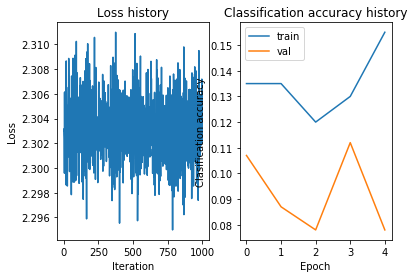

iteration [0 / 1000] : loss = 196.706757
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 / 1000] :

iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : loss = nan
iteration [280 / 1000] : loss = nan
iteration [281 / 1000] : loss = nan
iteration [282 / 1000] : loss = nan
iteration [283 / 1000] : loss = nan
iteration [284 / 1000] : loss = nan
iteration [285 / 1000] : loss = nan
iteration [286 / 1000] : loss = nan
iteration [287 / 1000] : loss = nan
iteration [288 / 1000] : loss = nan
iteration [289 / 1000] : loss = nan
iteration [290 / 1000] : loss = nan
iteration [291 / 1000] : loss = nan
iteration [292 / 1000] : loss = nan
iteration [293 / 1000] : loss = nan
iteration [294 / 1000] : loss = nan
iteration [295 / 1000] : loss = nan
iteration [296 / 1000] : loss = nan
iteration [297 / 1000] : loss = nan
iteration [298 / 1000] : los

iteration [519 / 1000] : loss = nan
iteration [520 / 1000] : loss = nan
iteration [521 / 1000] : loss = nan
iteration [522 / 1000] : loss = nan
iteration [523 / 1000] : loss = nan
iteration [524 / 1000] : loss = nan
iteration [525 / 1000] : loss = nan
iteration [526 / 1000] : loss = nan
iteration [527 / 1000] : loss = nan
iteration [528 / 1000] : loss = nan
iteration [529 / 1000] : loss = nan
iteration [530 / 1000] : loss = nan
iteration [531 / 1000] : loss = nan
iteration [532 / 1000] : loss = nan
iteration [533 / 1000] : loss = nan
iteration [534 / 1000] : loss = nan
iteration [535 / 1000] : loss = nan
iteration [536 / 1000] : loss = nan
iteration [537 / 1000] : loss = nan
iteration [538 / 1000] : loss = nan
iteration [539 / 1000] : loss = nan
iteration [540 / 1000] : loss = nan
iteration [541 / 1000] : loss = nan
iteration [542 / 1000] : loss = nan
iteration [543 / 1000] : loss = nan
iteration [544 / 1000] : loss = nan
iteration [545 / 1000] : loss = nan
iteration [546 / 1000] : los

iteration [765 / 1000] : loss = nan
iteration [766 / 1000] : loss = nan
iteration [767 / 1000] : loss = nan
iteration [768 / 1000] : loss = nan
iteration [769 / 1000] : loss = nan
iteration [770 / 1000] : loss = nan
iteration [771 / 1000] : loss = nan
iteration [772 / 1000] : loss = nan
iteration [773 / 1000] : loss = nan
iteration [774 / 1000] : loss = nan
iteration [775 / 1000] : loss = nan
iteration [776 / 1000] : loss = nan
iteration [777 / 1000] : loss = nan
iteration [778 / 1000] : loss = nan
iteration [779 / 1000] : loss = nan
iteration [780 / 1000] : loss = nan
iteration [781 / 1000] : loss = nan
iteration [782 / 1000] : loss = nan
iteration [783 / 1000] : loss = nan
iteration [784 / 1000] : loss = nan
iteration [785 / 1000] : loss = nan
iteration [786 / 1000] : loss = nan
iteration [787 / 1000] : loss = nan
iteration [788 / 1000] : loss = nan
iteration [789 / 1000] : loss = nan
iteration [790 / 1000] : loss = nan
iteration [791 / 1000] : loss = nan
iteration [792 / 1000] : los

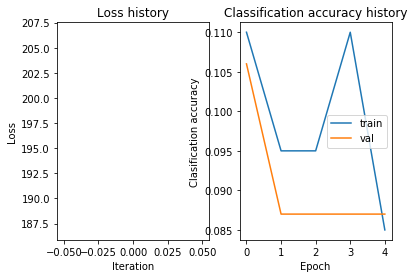

iteration [0 / 1000] : loss = 3.089201
iteration [1 / 1000] : loss = 785258.478466
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 /

iteration [268 / 1000] : loss = nan
iteration [269 / 1000] : loss = nan
iteration [270 / 1000] : loss = nan
iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : loss = nan
iteration [280 / 1000] : loss = nan
iteration [281 / 1000] : loss = nan
iteration [282 / 1000] : loss = nan
iteration [283 / 1000] : loss = nan
iteration [284 / 1000] : loss = nan
iteration [285 / 1000] : loss = nan
iteration [286 / 1000] : loss = nan
iteration [287 / 1000] : loss = nan
iteration [288 / 1000] : loss = nan
iteration [289 / 1000] : loss = nan
iteration [290 / 1000] : loss = nan
iteration [291 / 1000] : loss = nan
iteration [292 / 1000] : loss = nan
iteration [293 / 1000] : loss = nan
iteration [294 / 1000] : loss = nan
iteration [295 / 1000] : los

iteration [512 / 1000] : loss = nan
iteration [513 / 1000] : loss = nan
iteration [514 / 1000] : loss = nan
iteration [515 / 1000] : loss = nan
iteration [516 / 1000] : loss = nan
iteration [517 / 1000] : loss = nan
iteration [518 / 1000] : loss = nan
iteration [519 / 1000] : loss = nan
iteration [520 / 1000] : loss = nan
iteration [521 / 1000] : loss = nan
iteration [522 / 1000] : loss = nan
iteration [523 / 1000] : loss = nan
iteration [524 / 1000] : loss = nan
iteration [525 / 1000] : loss = nan
iteration [526 / 1000] : loss = nan
iteration [527 / 1000] : loss = nan
iteration [528 / 1000] : loss = nan
iteration [529 / 1000] : loss = nan
iteration [530 / 1000] : loss = nan
iteration [531 / 1000] : loss = nan
iteration [532 / 1000] : loss = nan
iteration [533 / 1000] : loss = nan
iteration [534 / 1000] : loss = nan
iteration [535 / 1000] : loss = nan
iteration [536 / 1000] : loss = nan
iteration [537 / 1000] : loss = nan
iteration [538 / 1000] : loss = nan
iteration [539 / 1000] : los

iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : loss = nan
iteration [759 / 1000] : loss = nan
iteration [760 / 1000] : loss = nan
iteration [761 / 1000] : loss = nan
iteration [762 / 1000] : loss = nan
iteration [763 / 1000] : loss = nan
iteration [764 / 1000] : loss = nan
iteration [765 / 1000] : loss = nan
iteration [766 / 1000] : loss = nan
iteration [767 / 1000] : loss = nan
iteration [768 / 1000] : loss = nan
iteration [769 / 1000] : loss = nan
iteration [770 / 1000] : loss = nan
iteration [771 / 1000] : loss = nan
iteration [772 / 1000] : loss = nan
iteration [773 / 1000] : loss = nan
iteration [774 / 1000] : loss = nan
iteration [775 / 1000] : loss = nan
iteration [776 / 1000] : loss = nan
iteration [777 / 1000] : loss = nan
iteration [778 / 1000] : loss = nan
iteration [779 / 1000] : loss = nan
iteration [780 / 1000] : loss = nan
iteration [781 / 1000] : loss = nan
iteration [782 / 1000] : loss = nan
iteration [783 / 1000] : loss = nan
iteration [784 / 1000] : los

iteration [998 / 1000] : loss = nan
iteration [999 / 1000] : loss = nan


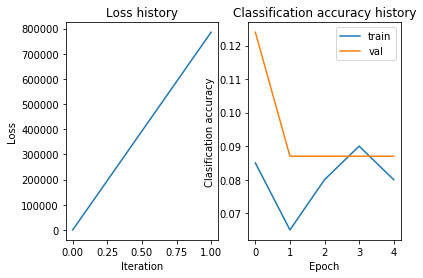

iteration [0 / 1000] : loss = 2.413395
iteration [1 / 1000] : loss = 2193.753016
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 / 1

iteration [262 / 1000] : loss = nan
iteration [263 / 1000] : loss = nan
iteration [264 / 1000] : loss = nan
iteration [265 / 1000] : loss = nan
iteration [266 / 1000] : loss = nan
iteration [267 / 1000] : loss = nan
iteration [268 / 1000] : loss = nan
iteration [269 / 1000] : loss = nan
iteration [270 / 1000] : loss = nan
iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : loss = nan
iteration [280 / 1000] : loss = nan
iteration [281 / 1000] : loss = nan
iteration [282 / 1000] : loss = nan
iteration [283 / 1000] : loss = nan
iteration [284 / 1000] : loss = nan
iteration [285 / 1000] : loss = nan
iteration [286 / 1000] : loss = nan
iteration [287 / 1000] : loss = nan
iteration [288 / 1000] : loss = nan
iteration [289 / 1000] : los

iteration [500 / 1000] : loss = nan
iteration [501 / 1000] : loss = nan
iteration [502 / 1000] : loss = nan
iteration [503 / 1000] : loss = nan
iteration [504 / 1000] : loss = nan
iteration [505 / 1000] : loss = nan
iteration [506 / 1000] : loss = nan
iteration [507 / 1000] : loss = nan
iteration [508 / 1000] : loss = nan
iteration [509 / 1000] : loss = nan
iteration [510 / 1000] : loss = nan
iteration [511 / 1000] : loss = nan
iteration [512 / 1000] : loss = nan
iteration [513 / 1000] : loss = nan
iteration [514 / 1000] : loss = nan
iteration [515 / 1000] : loss = nan
iteration [516 / 1000] : loss = nan
iteration [517 / 1000] : loss = nan
iteration [518 / 1000] : loss = nan
iteration [519 / 1000] : loss = nan
iteration [520 / 1000] : loss = nan
iteration [521 / 1000] : loss = nan
iteration [522 / 1000] : loss = nan
iteration [523 / 1000] : loss = nan
iteration [524 / 1000] : loss = nan
iteration [525 / 1000] : loss = nan
iteration [526 / 1000] : loss = nan
iteration [527 / 1000] : los

iteration [735 / 1000] : loss = nan
iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : loss = nan
iteration [749 / 1000] : loss = nan
iteration [750 / 1000] : loss = nan
iteration [751 / 1000] : loss = nan
iteration [752 / 1000] : loss = nan
iteration [753 / 1000] : loss = nan
iteration [754 / 1000] : loss = nan
iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : loss = nan
iteration [759 / 1000] : loss = nan
iteration [760 / 1000] : loss = nan
iteration [761 / 1000] : loss = nan
iteration [762 / 1000] : los

iteration [982 / 1000] : loss = nan
iteration [983 / 1000] : loss = nan
iteration [984 / 1000] : loss = nan
iteration [985 / 1000] : loss = nan
iteration [986 / 1000] : loss = nan
iteration [987 / 1000] : loss = nan
iteration [988 / 1000] : loss = nan
iteration [989 / 1000] : loss = nan
iteration [990 / 1000] : loss = nan
iteration [991 / 1000] : loss = nan
iteration [992 / 1000] : loss = nan
iteration [993 / 1000] : loss = nan
iteration [994 / 1000] : loss = nan
iteration [995 / 1000] : loss = nan
iteration [996 / 1000] : loss = nan
iteration [997 / 1000] : loss = nan
iteration [998 / 1000] : loss = nan
iteration [999 / 1000] : loss = nan


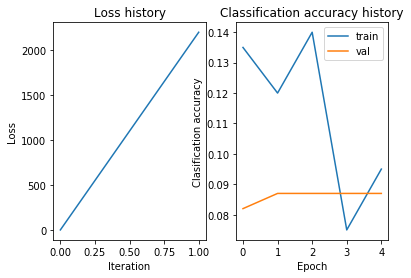

iteration [0 / 1000] : loss = 128.680996
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 / 1000] :

iteration [259 / 1000] : loss = nan
iteration [260 / 1000] : loss = nan
iteration [261 / 1000] : loss = nan
iteration [262 / 1000] : loss = nan
iteration [263 / 1000] : loss = nan
iteration [264 / 1000] : loss = nan
iteration [265 / 1000] : loss = nan
iteration [266 / 1000] : loss = nan
iteration [267 / 1000] : loss = nan
iteration [268 / 1000] : loss = nan
iteration [269 / 1000] : loss = nan
iteration [270 / 1000] : loss = nan
iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : loss = nan
iteration [280 / 1000] : loss = nan
iteration [281 / 1000] : loss = nan
iteration [282 / 1000] : loss = nan
iteration [283 / 1000] : loss = nan
iteration [284 / 1000] : loss = nan
iteration [285 / 1000] : loss = nan
iteration [286 / 1000] : los

iteration [523 / 1000] : loss = nan
iteration [524 / 1000] : loss = nan
iteration [525 / 1000] : loss = nan
iteration [526 / 1000] : loss = nan
iteration [527 / 1000] : loss = nan
iteration [528 / 1000] : loss = nan
iteration [529 / 1000] : loss = nan
iteration [530 / 1000] : loss = nan
iteration [531 / 1000] : loss = nan
iteration [532 / 1000] : loss = nan
iteration [533 / 1000] : loss = nan
iteration [534 / 1000] : loss = nan
iteration [535 / 1000] : loss = nan
iteration [536 / 1000] : loss = nan
iteration [537 / 1000] : loss = nan
iteration [538 / 1000] : loss = nan
iteration [539 / 1000] : loss = nan
iteration [540 / 1000] : loss = nan
iteration [541 / 1000] : loss = nan
iteration [542 / 1000] : loss = nan
iteration [543 / 1000] : loss = nan
iteration [544 / 1000] : loss = nan
iteration [545 / 1000] : loss = nan
iteration [546 / 1000] : loss = nan
iteration [547 / 1000] : loss = nan
iteration [548 / 1000] : loss = nan
iteration [549 / 1000] : loss = nan
iteration [550 / 1000] : los

iteration [761 / 1000] : loss = nan
iteration [762 / 1000] : loss = nan
iteration [763 / 1000] : loss = nan
iteration [764 / 1000] : loss = nan
iteration [765 / 1000] : loss = nan
iteration [766 / 1000] : loss = nan
iteration [767 / 1000] : loss = nan
iteration [768 / 1000] : loss = nan
iteration [769 / 1000] : loss = nan
iteration [770 / 1000] : loss = nan
iteration [771 / 1000] : loss = nan
iteration [772 / 1000] : loss = nan
iteration [773 / 1000] : loss = nan
iteration [774 / 1000] : loss = nan
iteration [775 / 1000] : loss = nan
iteration [776 / 1000] : loss = nan
iteration [777 / 1000] : loss = nan
iteration [778 / 1000] : loss = nan
iteration [779 / 1000] : loss = nan
iteration [780 / 1000] : loss = nan
iteration [781 / 1000] : loss = nan
iteration [782 / 1000] : loss = nan
iteration [783 / 1000] : loss = nan
iteration [784 / 1000] : loss = nan
iteration [785 / 1000] : loss = nan
iteration [786 / 1000] : loss = nan
iteration [787 / 1000] : loss = nan
iteration [788 / 1000] : los

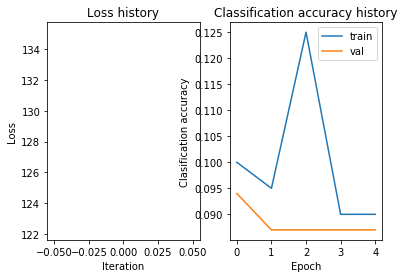

iteration [0 / 1000] : loss = 2.303143
iteration [1 / 1000] : loss = 2.302401
iteration [2 / 1000] : loss = 2.301651
iteration [3 / 1000] : loss = 2.302199
iteration [4 / 1000] : loss = 2.302797
iteration [5 / 1000] : loss = 2.303222
iteration [6 / 1000] : loss = 2.300799
iteration [7 / 1000] : loss = 2.304520
iteration [8 / 1000] : loss = 2.306647
iteration [9 / 1000] : loss = 2.302662
iteration [10 / 1000] : loss = 2.304880
iteration [11 / 1000] : loss = 2.305277
iteration [12 / 1000] : loss = 2.301197
iteration [13 / 1000] : loss = 2.302709
iteration [14 / 1000] : loss = 2.302763
iteration [15 / 1000] : loss = 2.304734
iteration [16 / 1000] : loss = 2.300036
iteration [17 / 1000] : loss = 2.302253
iteration [18 / 1000] : loss = 2.301004
iteration [19 / 1000] : loss = 2.300862
iteration [20 / 1000] : loss = 2.305191
iteration [21 / 1000] : loss = 2.304988
iteration [22 / 1000] : loss = 2.301566
iteration [23 / 1000] : loss = 2.303335
iteration [24 / 1000] : loss = 2.302334
iteration 

iteration [236 / 1000] : loss = 2.301756
iteration [237 / 1000] : loss = 2.300306
iteration [238 / 1000] : loss = 2.302492
iteration [239 / 1000] : loss = 2.302451
iteration [240 / 1000] : loss = 2.299096
iteration [241 / 1000] : loss = 2.300655
iteration [242 / 1000] : loss = 2.307683
iteration [243 / 1000] : loss = 2.306353
iteration [244 / 1000] : loss = 2.299403
iteration [245 / 1000] : loss = 2.303380
iteration [246 / 1000] : loss = 2.301590
iteration [247 / 1000] : loss = 2.306263
iteration [248 / 1000] : loss = 2.300088
iteration [249 / 1000] : loss = 2.305283
iteration [250 / 1000] : loss = 2.303697
iteration [251 / 1000] : loss = 2.300751
iteration [252 / 1000] : loss = 2.308275
iteration [253 / 1000] : loss = 2.300543
iteration [254 / 1000] : loss = 2.304210
iteration [255 / 1000] : loss = 2.298979
iteration [256 / 1000] : loss = 2.307960
iteration [257 / 1000] : loss = 2.302676
iteration [258 / 1000] : loss = 2.305166
iteration [259 / 1000] : loss = 2.304768
iteration [260 /

iteration [446 / 1000] : loss = 2.302318
iteration [447 / 1000] : loss = 2.303740
iteration [448 / 1000] : loss = 2.304838
iteration [449 / 1000] : loss = 2.303783
iteration [450 / 1000] : loss = 2.304172
iteration [451 / 1000] : loss = 2.300424
iteration [452 / 1000] : loss = 2.305297
iteration [453 / 1000] : loss = 2.302845
iteration [454 / 1000] : loss = 2.304700
iteration [455 / 1000] : loss = 2.302362
iteration [456 / 1000] : loss = 2.305606
iteration [457 / 1000] : loss = 2.301152
iteration [458 / 1000] : loss = 2.302976
iteration [459 / 1000] : loss = 2.302132
iteration [460 / 1000] : loss = 2.304346
iteration [461 / 1000] : loss = 2.301417
iteration [462 / 1000] : loss = 2.301978
iteration [463 / 1000] : loss = 2.304758
iteration [464 / 1000] : loss = 2.297875
iteration [465 / 1000] : loss = 2.306802
iteration [466 / 1000] : loss = 2.304568
iteration [467 / 1000] : loss = 2.303115
iteration [468 / 1000] : loss = 2.305381
iteration [469 / 1000] : loss = 2.303651
iteration [470 /

iteration [669 / 1000] : loss = 2.300870
iteration [670 / 1000] : loss = 2.301628
iteration [671 / 1000] : loss = 2.301564
iteration [672 / 1000] : loss = 2.302654
iteration [673 / 1000] : loss = 2.301511
iteration [674 / 1000] : loss = 2.300229
iteration [675 / 1000] : loss = 2.298612
iteration [676 / 1000] : loss = 2.305424
iteration [677 / 1000] : loss = 2.302054
iteration [678 / 1000] : loss = 2.302863
iteration [679 / 1000] : loss = 2.302627
iteration [680 / 1000] : loss = 2.308180
iteration [681 / 1000] : loss = 2.303287
iteration [682 / 1000] : loss = 2.305247
iteration [683 / 1000] : loss = 2.302188
iteration [684 / 1000] : loss = 2.302816
iteration [685 / 1000] : loss = 2.302889
iteration [686 / 1000] : loss = 2.306109
iteration [687 / 1000] : loss = 2.302510
iteration [688 / 1000] : loss = 2.302347
iteration [689 / 1000] : loss = 2.304217
iteration [690 / 1000] : loss = 2.303305
iteration [691 / 1000] : loss = 2.302532
iteration [692 / 1000] : loss = 2.305054
iteration [693 /

iteration [898 / 1000] : loss = 2.305186
iteration [899 / 1000] : loss = 2.304789
iteration [900 / 1000] : loss = 2.304871
iteration [901 / 1000] : loss = 2.304170
iteration [902 / 1000] : loss = 2.306205
iteration [903 / 1000] : loss = 2.305390
iteration [904 / 1000] : loss = 2.302398
iteration [905 / 1000] : loss = 2.304035
iteration [906 / 1000] : loss = 2.301609
iteration [907 / 1000] : loss = 2.304308
iteration [908 / 1000] : loss = 2.302241
iteration [909 / 1000] : loss = 2.305216
iteration [910 / 1000] : loss = 2.304156
iteration [911 / 1000] : loss = 2.302313
iteration [912 / 1000] : loss = 2.304130
iteration [913 / 1000] : loss = 2.301614
iteration [914 / 1000] : loss = 2.303230
iteration [915 / 1000] : loss = 2.303395
iteration [916 / 1000] : loss = 2.303081
iteration [917 / 1000] : loss = 2.301252
iteration [918 / 1000] : loss = 2.302146
iteration [919 / 1000] : loss = 2.303003
iteration [920 / 1000] : loss = 2.304463
iteration [921 / 1000] : loss = 2.304020
iteration [922 /

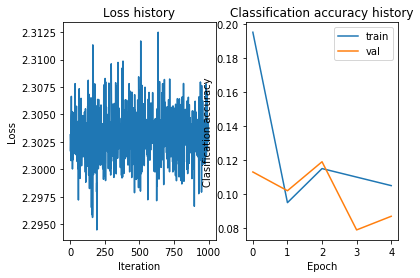

iteration [0 / 1000] : loss = 195.370505
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 / 1000] :

iteration [264 / 1000] : loss = nan
iteration [265 / 1000] : loss = nan
iteration [266 / 1000] : loss = nan
iteration [267 / 1000] : loss = nan
iteration [268 / 1000] : loss = nan
iteration [269 / 1000] : loss = nan
iteration [270 / 1000] : loss = nan
iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : loss = nan
iteration [280 / 1000] : loss = nan
iteration [281 / 1000] : loss = nan
iteration [282 / 1000] : loss = nan
iteration [283 / 1000] : loss = nan
iteration [284 / 1000] : loss = nan
iteration [285 / 1000] : loss = nan
iteration [286 / 1000] : loss = nan
iteration [287 / 1000] : loss = nan
iteration [288 / 1000] : loss = nan
iteration [289 / 1000] : loss = nan
iteration [290 / 1000] : loss = nan
iteration [291 / 1000] : los

iteration [513 / 1000] : loss = nan
iteration [514 / 1000] : loss = nan
iteration [515 / 1000] : loss = nan
iteration [516 / 1000] : loss = nan
iteration [517 / 1000] : loss = nan
iteration [518 / 1000] : loss = nan
iteration [519 / 1000] : loss = nan
iteration [520 / 1000] : loss = nan
iteration [521 / 1000] : loss = nan
iteration [522 / 1000] : loss = nan
iteration [523 / 1000] : loss = nan
iteration [524 / 1000] : loss = nan
iteration [525 / 1000] : loss = nan
iteration [526 / 1000] : loss = nan
iteration [527 / 1000] : loss = nan
iteration [528 / 1000] : loss = nan
iteration [529 / 1000] : loss = nan
iteration [530 / 1000] : loss = nan
iteration [531 / 1000] : loss = nan
iteration [532 / 1000] : loss = nan
iteration [533 / 1000] : loss = nan
iteration [534 / 1000] : loss = nan
iteration [535 / 1000] : loss = nan
iteration [536 / 1000] : loss = nan
iteration [537 / 1000] : loss = nan
iteration [538 / 1000] : loss = nan
iteration [539 / 1000] : loss = nan
iteration [540 / 1000] : los

iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : loss = nan
iteration [749 / 1000] : loss = nan
iteration [750 / 1000] : loss = nan
iteration [751 / 1000] : loss = nan
iteration [752 / 1000] : loss = nan
iteration [753 / 1000] : loss = nan
iteration [754 / 1000] : loss = nan
iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : loss = nan
iteration [759 / 1000] : loss = nan
iteration [760 / 1000] : loss = nan
iteration [761 / 1000] : loss = nan
iteration [762 / 1000] : loss = nan
iteration [763 / 1000] : loss = nan
iteration [764 / 1000] : loss = nan
iteration [765 / 1000] : loss = nan
iteration [766 / 1000] : loss = nan
iteration [767 / 1000] : loss = nan
iteration [768 / 1000] : loss = nan
iteration [769 / 1000] : los

iteration [978 / 1000] : loss = nan
iteration [979 / 1000] : loss = nan
iteration [980 / 1000] : loss = nan
iteration [981 / 1000] : loss = nan
iteration [982 / 1000] : loss = nan
iteration [983 / 1000] : loss = nan
iteration [984 / 1000] : loss = nan
iteration [985 / 1000] : loss = nan
iteration [986 / 1000] : loss = nan
iteration [987 / 1000] : loss = nan
iteration [988 / 1000] : loss = nan
iteration [989 / 1000] : loss = nan
iteration [990 / 1000] : loss = nan
iteration [991 / 1000] : loss = nan
iteration [992 / 1000] : loss = nan
iteration [993 / 1000] : loss = nan
iteration [994 / 1000] : loss = nan
iteration [995 / 1000] : loss = nan
iteration [996 / 1000] : loss = nan
iteration [997 / 1000] : loss = nan
iteration [998 / 1000] : loss = nan
iteration [999 / 1000] : loss = nan


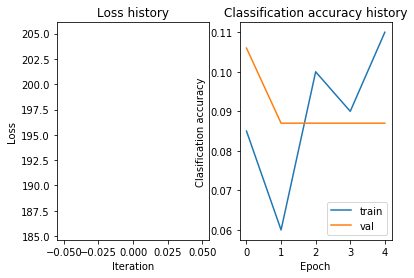

iteration [0 / 1000] : loss = 3.085470
iteration [1 / 1000] : loss = 552366.062878
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 /

iteration [233 / 1000] : loss = nan
iteration [234 / 1000] : loss = nan
iteration [235 / 1000] : loss = nan
iteration [236 / 1000] : loss = nan
iteration [237 / 1000] : loss = nan
iteration [238 / 1000] : loss = nan
iteration [239 / 1000] : loss = nan
iteration [240 / 1000] : loss = nan
iteration [241 / 1000] : loss = nan
iteration [242 / 1000] : loss = nan
iteration [243 / 1000] : loss = nan
iteration [244 / 1000] : loss = nan
iteration [245 / 1000] : loss = nan
iteration [246 / 1000] : loss = nan
iteration [247 / 1000] : loss = nan
iteration [248 / 1000] : loss = nan
iteration [249 / 1000] : loss = nan
iteration [250 / 1000] : loss = nan
iteration [251 / 1000] : loss = nan
iteration [252 / 1000] : loss = nan
iteration [253 / 1000] : loss = nan
iteration [254 / 1000] : loss = nan
iteration [255 / 1000] : loss = nan
iteration [256 / 1000] : loss = nan
iteration [257 / 1000] : loss = nan
iteration [258 / 1000] : loss = nan
iteration [259 / 1000] : loss = nan
iteration [260 / 1000] : los

iteration [464 / 1000] : loss = nan
iteration [465 / 1000] : loss = nan
iteration [466 / 1000] : loss = nan
iteration [467 / 1000] : loss = nan
iteration [468 / 1000] : loss = nan
iteration [469 / 1000] : loss = nan
iteration [470 / 1000] : loss = nan
iteration [471 / 1000] : loss = nan
iteration [472 / 1000] : loss = nan
iteration [473 / 1000] : loss = nan
iteration [474 / 1000] : loss = nan
iteration [475 / 1000] : loss = nan
iteration [476 / 1000] : loss = nan
iteration [477 / 1000] : loss = nan
iteration [478 / 1000] : loss = nan
iteration [479 / 1000] : loss = nan
iteration [480 / 1000] : loss = nan
iteration [481 / 1000] : loss = nan
iteration [482 / 1000] : loss = nan
iteration [483 / 1000] : loss = nan
iteration [484 / 1000] : loss = nan
iteration [485 / 1000] : loss = nan
iteration [486 / 1000] : loss = nan
iteration [487 / 1000] : loss = nan
iteration [488 / 1000] : loss = nan
iteration [489 / 1000] : loss = nan
iteration [490 / 1000] : loss = nan
iteration [491 / 1000] : los

iteration [721 / 1000] : loss = nan
iteration [722 / 1000] : loss = nan
iteration [723 / 1000] : loss = nan
iteration [724 / 1000] : loss = nan
iteration [725 / 1000] : loss = nan
iteration [726 / 1000] : loss = nan
iteration [727 / 1000] : loss = nan
iteration [728 / 1000] : loss = nan
iteration [729 / 1000] : loss = nan
iteration [730 / 1000] : loss = nan
iteration [731 / 1000] : loss = nan
iteration [732 / 1000] : loss = nan
iteration [733 / 1000] : loss = nan
iteration [734 / 1000] : loss = nan
iteration [735 / 1000] : loss = nan
iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : los

iteration [958 / 1000] : loss = nan
iteration [959 / 1000] : loss = nan
iteration [960 / 1000] : loss = nan
iteration [961 / 1000] : loss = nan
iteration [962 / 1000] : loss = nan
iteration [963 / 1000] : loss = nan
iteration [964 / 1000] : loss = nan
iteration [965 / 1000] : loss = nan
iteration [966 / 1000] : loss = nan
iteration [967 / 1000] : loss = nan
iteration [968 / 1000] : loss = nan
iteration [969 / 1000] : loss = nan
iteration [970 / 1000] : loss = nan
iteration [971 / 1000] : loss = nan
iteration [972 / 1000] : loss = nan
iteration [973 / 1000] : loss = nan
iteration [974 / 1000] : loss = nan
iteration [975 / 1000] : loss = nan
iteration [976 / 1000] : loss = nan
iteration [977 / 1000] : loss = nan
iteration [978 / 1000] : loss = nan
iteration [979 / 1000] : loss = nan
iteration [980 / 1000] : loss = nan
iteration [981 / 1000] : loss = nan
iteration [982 / 1000] : loss = nan
iteration [983 / 1000] : loss = nan
iteration [984 / 1000] : loss = nan
iteration [985 / 1000] : los

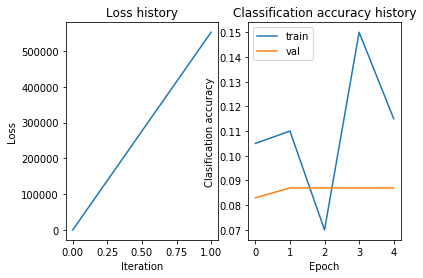

iteration [0 / 1000] : loss = 2.413854
iteration [1 / 1000] : loss = 1553.981885
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 / 1

iteration [232 / 1000] : loss = nan
iteration [233 / 1000] : loss = nan
iteration [234 / 1000] : loss = nan
iteration [235 / 1000] : loss = nan
iteration [236 / 1000] : loss = nan
iteration [237 / 1000] : loss = nan
iteration [238 / 1000] : loss = nan
iteration [239 / 1000] : loss = nan
iteration [240 / 1000] : loss = nan
iteration [241 / 1000] : loss = nan
iteration [242 / 1000] : loss = nan
iteration [243 / 1000] : loss = nan
iteration [244 / 1000] : loss = nan
iteration [245 / 1000] : loss = nan
iteration [246 / 1000] : loss = nan
iteration [247 / 1000] : loss = nan
iteration [248 / 1000] : loss = nan
iteration [249 / 1000] : loss = nan
iteration [250 / 1000] : loss = nan
iteration [251 / 1000] : loss = nan
iteration [252 / 1000] : loss = nan
iteration [253 / 1000] : loss = nan
iteration [254 / 1000] : loss = nan
iteration [255 / 1000] : loss = nan
iteration [256 / 1000] : loss = nan
iteration [257 / 1000] : loss = nan
iteration [258 / 1000] : loss = nan
iteration [259 / 1000] : los

iteration [471 / 1000] : loss = nan
iteration [472 / 1000] : loss = nan
iteration [473 / 1000] : loss = nan
iteration [474 / 1000] : loss = nan
iteration [475 / 1000] : loss = nan
iteration [476 / 1000] : loss = nan
iteration [477 / 1000] : loss = nan
iteration [478 / 1000] : loss = nan
iteration [479 / 1000] : loss = nan
iteration [480 / 1000] : loss = nan
iteration [481 / 1000] : loss = nan
iteration [482 / 1000] : loss = nan
iteration [483 / 1000] : loss = nan
iteration [484 / 1000] : loss = nan
iteration [485 / 1000] : loss = nan
iteration [486 / 1000] : loss = nan
iteration [487 / 1000] : loss = nan
iteration [488 / 1000] : loss = nan
iteration [489 / 1000] : loss = nan
iteration [490 / 1000] : loss = nan
iteration [491 / 1000] : loss = nan
iteration [492 / 1000] : loss = nan
iteration [493 / 1000] : loss = nan
iteration [494 / 1000] : loss = nan
iteration [495 / 1000] : loss = nan
iteration [496 / 1000] : loss = nan
iteration [497 / 1000] : loss = nan
iteration [498 / 1000] : los

iteration [705 / 1000] : loss = nan
iteration [706 / 1000] : loss = nan
iteration [707 / 1000] : loss = nan
iteration [708 / 1000] : loss = nan
iteration [709 / 1000] : loss = nan
iteration [710 / 1000] : loss = nan
iteration [711 / 1000] : loss = nan
iteration [712 / 1000] : loss = nan
iteration [713 / 1000] : loss = nan
iteration [714 / 1000] : loss = nan
iteration [715 / 1000] : loss = nan
iteration [716 / 1000] : loss = nan
iteration [717 / 1000] : loss = nan
iteration [718 / 1000] : loss = nan
iteration [719 / 1000] : loss = nan
iteration [720 / 1000] : loss = nan
iteration [721 / 1000] : loss = nan
iteration [722 / 1000] : loss = nan
iteration [723 / 1000] : loss = nan
iteration [724 / 1000] : loss = nan
iteration [725 / 1000] : loss = nan
iteration [726 / 1000] : loss = nan
iteration [727 / 1000] : loss = nan
iteration [728 / 1000] : loss = nan
iteration [729 / 1000] : loss = nan
iteration [730 / 1000] : loss = nan
iteration [731 / 1000] : loss = nan
iteration [732 / 1000] : los

iteration [943 / 1000] : loss = nan
iteration [944 / 1000] : loss = nan
iteration [945 / 1000] : loss = nan
iteration [946 / 1000] : loss = nan
iteration [947 / 1000] : loss = nan
iteration [948 / 1000] : loss = nan
iteration [949 / 1000] : loss = nan
iteration [950 / 1000] : loss = nan
iteration [951 / 1000] : loss = nan
iteration [952 / 1000] : loss = nan
iteration [953 / 1000] : loss = nan
iteration [954 / 1000] : loss = nan
iteration [955 / 1000] : loss = nan
iteration [956 / 1000] : loss = nan
iteration [957 / 1000] : loss = nan
iteration [958 / 1000] : loss = nan
iteration [959 / 1000] : loss = nan
iteration [960 / 1000] : loss = nan
iteration [961 / 1000] : loss = nan
iteration [962 / 1000] : loss = nan
iteration [963 / 1000] : loss = nan
iteration [964 / 1000] : loss = nan
iteration [965 / 1000] : loss = nan
iteration [966 / 1000] : loss = nan
iteration [967 / 1000] : loss = nan
iteration [968 / 1000] : loss = nan
iteration [969 / 1000] : loss = nan
iteration [970 / 1000] : los

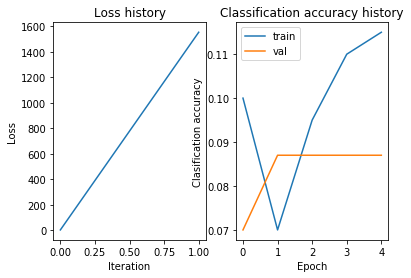

iteration [0 / 1000] : loss = 129.374885
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = nan
iteration [24 / 1000] : loss = nan
iteration [25 / 1000] : loss = nan
iteration [26 / 1000] : loss = nan
iteration [27 / 1000] : loss = nan
iteration [28 / 1000] :

iteration [232 / 1000] : loss = nan
iteration [233 / 1000] : loss = nan
iteration [234 / 1000] : loss = nan
iteration [235 / 1000] : loss = nan
iteration [236 / 1000] : loss = nan
iteration [237 / 1000] : loss = nan
iteration [238 / 1000] : loss = nan
iteration [239 / 1000] : loss = nan
iteration [240 / 1000] : loss = nan
iteration [241 / 1000] : loss = nan
iteration [242 / 1000] : loss = nan
iteration [243 / 1000] : loss = nan
iteration [244 / 1000] : loss = nan
iteration [245 / 1000] : loss = nan
iteration [246 / 1000] : loss = nan
iteration [247 / 1000] : loss = nan
iteration [248 / 1000] : loss = nan
iteration [249 / 1000] : loss = nan
iteration [250 / 1000] : loss = nan
iteration [251 / 1000] : loss = nan
iteration [252 / 1000] : loss = nan
iteration [253 / 1000] : loss = nan
iteration [254 / 1000] : loss = nan
iteration [255 / 1000] : loss = nan
iteration [256 / 1000] : loss = nan
iteration [257 / 1000] : loss = nan
iteration [258 / 1000] : loss = nan
iteration [259 / 1000] : los

iteration [471 / 1000] : loss = nan
iteration [472 / 1000] : loss = nan
iteration [473 / 1000] : loss = nan
iteration [474 / 1000] : loss = nan
iteration [475 / 1000] : loss = nan
iteration [476 / 1000] : loss = nan
iteration [477 / 1000] : loss = nan
iteration [478 / 1000] : loss = nan
iteration [479 / 1000] : loss = nan
iteration [480 / 1000] : loss = nan
iteration [481 / 1000] : loss = nan
iteration [482 / 1000] : loss = nan
iteration [483 / 1000] : loss = nan
iteration [484 / 1000] : loss = nan
iteration [485 / 1000] : loss = nan
iteration [486 / 1000] : loss = nan
iteration [487 / 1000] : loss = nan
iteration [488 / 1000] : loss = nan
iteration [489 / 1000] : loss = nan
iteration [490 / 1000] : loss = nan
iteration [491 / 1000] : loss = nan
iteration [492 / 1000] : loss = nan
iteration [493 / 1000] : loss = nan
iteration [494 / 1000] : loss = nan
iteration [495 / 1000] : loss = nan
iteration [496 / 1000] : loss = nan
iteration [497 / 1000] : loss = nan
iteration [498 / 1000] : los

iteration [734 / 1000] : loss = nan
iteration [735 / 1000] : loss = nan
iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : loss = nan
iteration [749 / 1000] : loss = nan
iteration [750 / 1000] : loss = nan
iteration [751 / 1000] : loss = nan
iteration [752 / 1000] : loss = nan
iteration [753 / 1000] : loss = nan
iteration [754 / 1000] : loss = nan
iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : loss = nan
iteration [759 / 1000] : loss = nan
iteration [760 / 1000] : loss = nan
iteration [761 / 1000] : los

iteration [966 / 1000] : loss = nan
iteration [967 / 1000] : loss = nan
iteration [968 / 1000] : loss = nan
iteration [969 / 1000] : loss = nan
iteration [970 / 1000] : loss = nan
iteration [971 / 1000] : loss = nan
iteration [972 / 1000] : loss = nan
iteration [973 / 1000] : loss = nan
iteration [974 / 1000] : loss = nan
iteration [975 / 1000] : loss = nan
iteration [976 / 1000] : loss = nan
iteration [977 / 1000] : loss = nan
iteration [978 / 1000] : loss = nan
iteration [979 / 1000] : loss = nan
iteration [980 / 1000] : loss = nan
iteration [981 / 1000] : loss = nan
iteration [982 / 1000] : loss = nan
iteration [983 / 1000] : loss = nan
iteration [984 / 1000] : loss = nan
iteration [985 / 1000] : loss = nan
iteration [986 / 1000] : loss = nan
iteration [987 / 1000] : loss = nan
iteration [988 / 1000] : loss = nan
iteration [989 / 1000] : loss = nan
iteration [990 / 1000] : loss = nan
iteration [991 / 1000] : loss = nan
iteration [992 / 1000] : loss = nan
iteration [993 / 1000] : los

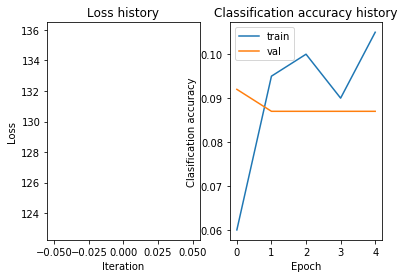

iteration [0 / 1000] : loss = 2.303148
iteration [1 / 1000] : loss = 2.861527
iteration [2 / 1000] : loss = 475.939582
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28

iteration [237 / 1000] : loss = nan
iteration [238 / 1000] : loss = nan
iteration [239 / 1000] : loss = nan
iteration [240 / 1000] : loss = nan
iteration [241 / 1000] : loss = nan
iteration [242 / 1000] : loss = nan
iteration [243 / 1000] : loss = nan
iteration [244 / 1000] : loss = nan
iteration [245 / 1000] : loss = nan
iteration [246 / 1000] : loss = nan
iteration [247 / 1000] : loss = nan
iteration [248 / 1000] : loss = nan
iteration [249 / 1000] : loss = nan
iteration [250 / 1000] : loss = nan
iteration [251 / 1000] : loss = nan
iteration [252 / 1000] : loss = nan
iteration [253 / 1000] : loss = nan
iteration [254 / 1000] : loss = nan
iteration [255 / 1000] : loss = nan
iteration [256 / 1000] : loss = nan
iteration [257 / 1000] : loss = nan
iteration [258 / 1000] : loss = nan
iteration [259 / 1000] : loss = nan
iteration [260 / 1000] : loss = nan
iteration [261 / 1000] : loss = nan
iteration [262 / 1000] : loss = nan
iteration [263 / 1000] : loss = nan
iteration [264 / 1000] : los

iteration [500 / 1000] : loss = nan
iteration [501 / 1000] : loss = nan
iteration [502 / 1000] : loss = nan
iteration [503 / 1000] : loss = nan
iteration [504 / 1000] : loss = nan
iteration [505 / 1000] : loss = nan
iteration [506 / 1000] : loss = nan
iteration [507 / 1000] : loss = nan
iteration [508 / 1000] : loss = nan
iteration [509 / 1000] : loss = nan
iteration [510 / 1000] : loss = nan
iteration [511 / 1000] : loss = nan
iteration [512 / 1000] : loss = nan
iteration [513 / 1000] : loss = nan
iteration [514 / 1000] : loss = nan
iteration [515 / 1000] : loss = nan
iteration [516 / 1000] : loss = nan
iteration [517 / 1000] : loss = nan
iteration [518 / 1000] : loss = nan
iteration [519 / 1000] : loss = nan
iteration [520 / 1000] : loss = nan
iteration [521 / 1000] : loss = nan
iteration [522 / 1000] : loss = nan
iteration [523 / 1000] : loss = nan
iteration [524 / 1000] : loss = nan
iteration [525 / 1000] : loss = nan
iteration [526 / 1000] : loss = nan
iteration [527 / 1000] : los

iteration [732 / 1000] : loss = nan
iteration [733 / 1000] : loss = nan
iteration [734 / 1000] : loss = nan
iteration [735 / 1000] : loss = nan
iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : loss = nan
iteration [749 / 1000] : loss = nan
iteration [750 / 1000] : loss = nan
iteration [751 / 1000] : loss = nan
iteration [752 / 1000] : loss = nan
iteration [753 / 1000] : loss = nan
iteration [754 / 1000] : loss = nan
iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : loss = nan
iteration [759 / 1000] : los

iteration [985 / 1000] : loss = nan
iteration [986 / 1000] : loss = nan
iteration [987 / 1000] : loss = nan
iteration [988 / 1000] : loss = nan
iteration [989 / 1000] : loss = nan
iteration [990 / 1000] : loss = nan
iteration [991 / 1000] : loss = nan
iteration [992 / 1000] : loss = nan
iteration [993 / 1000] : loss = nan
iteration [994 / 1000] : loss = nan
iteration [995 / 1000] : loss = nan
iteration [996 / 1000] : loss = nan
iteration [997 / 1000] : loss = nan
iteration [998 / 1000] : loss = nan
iteration [999 / 1000] : loss = nan


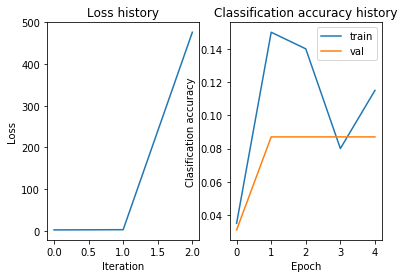

iteration [0 / 1000] : loss = 195.796974
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = nan
iteration [24 / 1000] : loss = nan
iteration [25 / 1000] : loss = nan
iteration [26 / 1000] : loss = nan
iteration [27 / 1000] : loss = nan
iteration [28 / 1000] :

iteration [241 / 1000] : loss = nan
iteration [242 / 1000] : loss = nan
iteration [243 / 1000] : loss = nan
iteration [244 / 1000] : loss = nan
iteration [245 / 1000] : loss = nan
iteration [246 / 1000] : loss = nan
iteration [247 / 1000] : loss = nan
iteration [248 / 1000] : loss = nan
iteration [249 / 1000] : loss = nan
iteration [250 / 1000] : loss = nan
iteration [251 / 1000] : loss = nan
iteration [252 / 1000] : loss = nan
iteration [253 / 1000] : loss = nan
iteration [254 / 1000] : loss = nan
iteration [255 / 1000] : loss = nan
iteration [256 / 1000] : loss = nan
iteration [257 / 1000] : loss = nan
iteration [258 / 1000] : loss = nan
iteration [259 / 1000] : loss = nan
iteration [260 / 1000] : loss = nan
iteration [261 / 1000] : loss = nan
iteration [262 / 1000] : loss = nan
iteration [263 / 1000] : loss = nan
iteration [264 / 1000] : loss = nan
iteration [265 / 1000] : loss = nan
iteration [266 / 1000] : loss = nan
iteration [267 / 1000] : loss = nan
iteration [268 / 1000] : los

iteration [471 / 1000] : loss = nan
iteration [472 / 1000] : loss = nan
iteration [473 / 1000] : loss = nan
iteration [474 / 1000] : loss = nan
iteration [475 / 1000] : loss = nan
iteration [476 / 1000] : loss = nan
iteration [477 / 1000] : loss = nan
iteration [478 / 1000] : loss = nan
iteration [479 / 1000] : loss = nan
iteration [480 / 1000] : loss = nan
iteration [481 / 1000] : loss = nan
iteration [482 / 1000] : loss = nan
iteration [483 / 1000] : loss = nan
iteration [484 / 1000] : loss = nan
iteration [485 / 1000] : loss = nan
iteration [486 / 1000] : loss = nan
iteration [487 / 1000] : loss = nan
iteration [488 / 1000] : loss = nan
iteration [489 / 1000] : loss = nan
iteration [490 / 1000] : loss = nan
iteration [491 / 1000] : loss = nan
iteration [492 / 1000] : loss = nan
iteration [493 / 1000] : loss = nan
iteration [494 / 1000] : loss = nan
iteration [495 / 1000] : loss = nan
iteration [496 / 1000] : loss = nan
iteration [497 / 1000] : loss = nan
iteration [498 / 1000] : los

iteration [703 / 1000] : loss = nan
iteration [704 / 1000] : loss = nan
iteration [705 / 1000] : loss = nan
iteration [706 / 1000] : loss = nan
iteration [707 / 1000] : loss = nan
iteration [708 / 1000] : loss = nan
iteration [709 / 1000] : loss = nan
iteration [710 / 1000] : loss = nan
iteration [711 / 1000] : loss = nan
iteration [712 / 1000] : loss = nan
iteration [713 / 1000] : loss = nan
iteration [714 / 1000] : loss = nan
iteration [715 / 1000] : loss = nan
iteration [716 / 1000] : loss = nan
iteration [717 / 1000] : loss = nan
iteration [718 / 1000] : loss = nan
iteration [719 / 1000] : loss = nan
iteration [720 / 1000] : loss = nan
iteration [721 / 1000] : loss = nan
iteration [722 / 1000] : loss = nan
iteration [723 / 1000] : loss = nan
iteration [724 / 1000] : loss = nan
iteration [725 / 1000] : loss = nan
iteration [726 / 1000] : loss = nan
iteration [727 / 1000] : loss = nan
iteration [728 / 1000] : loss = nan
iteration [729 / 1000] : loss = nan
iteration [730 / 1000] : los

iteration [932 / 1000] : loss = nan
iteration [933 / 1000] : loss = nan
iteration [934 / 1000] : loss = nan
iteration [935 / 1000] : loss = nan
iteration [936 / 1000] : loss = nan
iteration [937 / 1000] : loss = nan
iteration [938 / 1000] : loss = nan
iteration [939 / 1000] : loss = nan
iteration [940 / 1000] : loss = nan
iteration [941 / 1000] : loss = nan
iteration [942 / 1000] : loss = nan
iteration [943 / 1000] : loss = nan
iteration [944 / 1000] : loss = nan
iteration [945 / 1000] : loss = nan
iteration [946 / 1000] : loss = nan
iteration [947 / 1000] : loss = nan
iteration [948 / 1000] : loss = nan
iteration [949 / 1000] : loss = nan
iteration [950 / 1000] : loss = nan
iteration [951 / 1000] : loss = nan
iteration [952 / 1000] : loss = nan
iteration [953 / 1000] : loss = nan
iteration [954 / 1000] : loss = nan
iteration [955 / 1000] : loss = nan
iteration [956 / 1000] : loss = nan
iteration [957 / 1000] : loss = nan
iteration [958 / 1000] : loss = nan
iteration [959 / 1000] : los

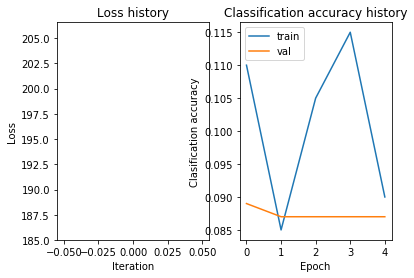

iteration [0 / 1000] : loss = 3.082212
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 / 1000] : l

iteration [231 / 1000] : loss = nan
iteration [232 / 1000] : loss = nan
iteration [233 / 1000] : loss = nan
iteration [234 / 1000] : loss = nan
iteration [235 / 1000] : loss = nan
iteration [236 / 1000] : loss = nan
iteration [237 / 1000] : loss = nan
iteration [238 / 1000] : loss = nan
iteration [239 / 1000] : loss = nan
iteration [240 / 1000] : loss = nan
iteration [241 / 1000] : loss = nan
iteration [242 / 1000] : loss = nan
iteration [243 / 1000] : loss = nan
iteration [244 / 1000] : loss = nan
iteration [245 / 1000] : loss = nan
iteration [246 / 1000] : loss = nan
iteration [247 / 1000] : loss = nan
iteration [248 / 1000] : loss = nan
iteration [249 / 1000] : loss = nan
iteration [250 / 1000] : loss = nan
iteration [251 / 1000] : loss = nan
iteration [252 / 1000] : loss = nan
iteration [253 / 1000] : loss = nan
iteration [254 / 1000] : loss = nan
iteration [255 / 1000] : loss = nan
iteration [256 / 1000] : loss = nan
iteration [257 / 1000] : loss = nan
iteration [258 / 1000] : los

iteration [496 / 1000] : loss = nan
iteration [497 / 1000] : loss = nan
iteration [498 / 1000] : loss = nan
iteration [499 / 1000] : loss = nan
iteration [500 / 1000] : loss = nan
iteration [501 / 1000] : loss = nan
iteration [502 / 1000] : loss = nan
iteration [503 / 1000] : loss = nan
iteration [504 / 1000] : loss = nan
iteration [505 / 1000] : loss = nan
iteration [506 / 1000] : loss = nan
iteration [507 / 1000] : loss = nan
iteration [508 / 1000] : loss = nan
iteration [509 / 1000] : loss = nan
iteration [510 / 1000] : loss = nan
iteration [511 / 1000] : loss = nan
iteration [512 / 1000] : loss = nan
iteration [513 / 1000] : loss = nan
iteration [514 / 1000] : loss = nan
iteration [515 / 1000] : loss = nan
iteration [516 / 1000] : loss = nan
iteration [517 / 1000] : loss = nan
iteration [518 / 1000] : loss = nan
iteration [519 / 1000] : loss = nan
iteration [520 / 1000] : loss = nan
iteration [521 / 1000] : loss = nan
iteration [522 / 1000] : loss = nan
iteration [523 / 1000] : los

iteration [733 / 1000] : loss = nan
iteration [734 / 1000] : loss = nan
iteration [735 / 1000] : loss = nan
iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : loss = nan
iteration [749 / 1000] : loss = nan
iteration [750 / 1000] : loss = nan
iteration [751 / 1000] : loss = nan
iteration [752 / 1000] : loss = nan
iteration [753 / 1000] : loss = nan
iteration [754 / 1000] : loss = nan
iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : loss = nan
iteration [759 / 1000] : loss = nan
iteration [760 / 1000] : los

iteration [967 / 1000] : loss = nan
iteration [968 / 1000] : loss = nan
iteration [969 / 1000] : loss = nan
iteration [970 / 1000] : loss = nan
iteration [971 / 1000] : loss = nan
iteration [972 / 1000] : loss = nan
iteration [973 / 1000] : loss = nan
iteration [974 / 1000] : loss = nan
iteration [975 / 1000] : loss = nan
iteration [976 / 1000] : loss = nan
iteration [977 / 1000] : loss = nan
iteration [978 / 1000] : loss = nan
iteration [979 / 1000] : loss = nan
iteration [980 / 1000] : loss = nan
iteration [981 / 1000] : loss = nan
iteration [982 / 1000] : loss = nan
iteration [983 / 1000] : loss = nan
iteration [984 / 1000] : loss = nan
iteration [985 / 1000] : loss = nan
iteration [986 / 1000] : loss = nan
iteration [987 / 1000] : loss = nan
iteration [988 / 1000] : loss = nan
iteration [989 / 1000] : loss = nan
iteration [990 / 1000] : loss = nan
iteration [991 / 1000] : loss = nan
iteration [992 / 1000] : loss = nan
iteration [993 / 1000] : loss = nan
iteration [994 / 1000] : los

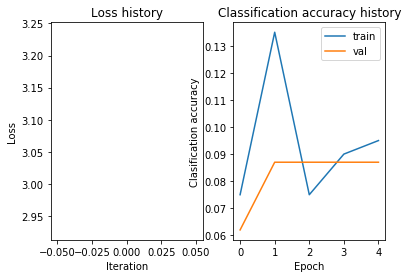

iteration [0 / 1000] : loss = 2.413011
iteration [1 / 1000] : loss = 4438181.547331
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 

iteration [252 / 1000] : loss = nan
iteration [253 / 1000] : loss = nan
iteration [254 / 1000] : loss = nan
iteration [255 / 1000] : loss = nan
iteration [256 / 1000] : loss = nan
iteration [257 / 1000] : loss = nan
iteration [258 / 1000] : loss = nan
iteration [259 / 1000] : loss = nan
iteration [260 / 1000] : loss = nan
iteration [261 / 1000] : loss = nan
iteration [262 / 1000] : loss = nan
iteration [263 / 1000] : loss = nan
iteration [264 / 1000] : loss = nan
iteration [265 / 1000] : loss = nan
iteration [266 / 1000] : loss = nan
iteration [267 / 1000] : loss = nan
iteration [268 / 1000] : loss = nan
iteration [269 / 1000] : loss = nan
iteration [270 / 1000] : loss = nan
iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : los

iteration [488 / 1000] : loss = nan
iteration [489 / 1000] : loss = nan
iteration [490 / 1000] : loss = nan
iteration [491 / 1000] : loss = nan
iteration [492 / 1000] : loss = nan
iteration [493 / 1000] : loss = nan
iteration [494 / 1000] : loss = nan
iteration [495 / 1000] : loss = nan
iteration [496 / 1000] : loss = nan
iteration [497 / 1000] : loss = nan
iteration [498 / 1000] : loss = nan
iteration [499 / 1000] : loss = nan
iteration [500 / 1000] : loss = nan
iteration [501 / 1000] : loss = nan
iteration [502 / 1000] : loss = nan
iteration [503 / 1000] : loss = nan
iteration [504 / 1000] : loss = nan
iteration [505 / 1000] : loss = nan
iteration [506 / 1000] : loss = nan
iteration [507 / 1000] : loss = nan
iteration [508 / 1000] : loss = nan
iteration [509 / 1000] : loss = nan
iteration [510 / 1000] : loss = nan
iteration [511 / 1000] : loss = nan
iteration [512 / 1000] : loss = nan
iteration [513 / 1000] : loss = nan
iteration [514 / 1000] : loss = nan
iteration [515 / 1000] : los

iteration [731 / 1000] : loss = nan
iteration [732 / 1000] : loss = nan
iteration [733 / 1000] : loss = nan
iteration [734 / 1000] : loss = nan
iteration [735 / 1000] : loss = nan
iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : loss = nan
iteration [749 / 1000] : loss = nan
iteration [750 / 1000] : loss = nan
iteration [751 / 1000] : loss = nan
iteration [752 / 1000] : loss = nan
iteration [753 / 1000] : loss = nan
iteration [754 / 1000] : loss = nan
iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : los

iteration [959 / 1000] : loss = nan
iteration [960 / 1000] : loss = nan
iteration [961 / 1000] : loss = nan
iteration [962 / 1000] : loss = nan
iteration [963 / 1000] : loss = nan
iteration [964 / 1000] : loss = nan
iteration [965 / 1000] : loss = nan
iteration [966 / 1000] : loss = nan
iteration [967 / 1000] : loss = nan
iteration [968 / 1000] : loss = nan
iteration [969 / 1000] : loss = nan
iteration [970 / 1000] : loss = nan
iteration [971 / 1000] : loss = nan
iteration [972 / 1000] : loss = nan
iteration [973 / 1000] : loss = nan
iteration [974 / 1000] : loss = nan
iteration [975 / 1000] : loss = nan
iteration [976 / 1000] : loss = nan
iteration [977 / 1000] : loss = nan
iteration [978 / 1000] : loss = nan
iteration [979 / 1000] : loss = nan
iteration [980 / 1000] : loss = nan
iteration [981 / 1000] : loss = nan
iteration [982 / 1000] : loss = nan
iteration [983 / 1000] : loss = nan
iteration [984 / 1000] : loss = nan
iteration [985 / 1000] : loss = nan
iteration [986 / 1000] : los

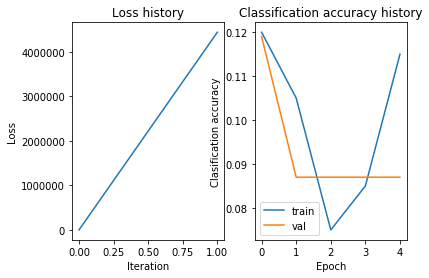

iteration [0 / 1000] : loss = 129.483774
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = nan
iteration [17 / 1000] : loss = nan
iteration [18 / 1000] : loss = nan
iteration [19 / 1000] : loss = nan
iteration [20 / 1000] : loss = nan
iteration [21 / 1000] : loss = nan
iteration [22 / 1000] : loss = nan
iteration [23 / 1000] : loss = nan
iteration [24 / 1000] : loss = nan
iteration [25 / 1000] : loss = nan
iteration [26 / 1000] : loss = nan
iteration [27 / 1000] : loss = nan
iteration [28 / 1000] :

iteration [261 / 1000] : loss = nan
iteration [262 / 1000] : loss = nan
iteration [263 / 1000] : loss = nan
iteration [264 / 1000] : loss = nan
iteration [265 / 1000] : loss = nan
iteration [266 / 1000] : loss = nan
iteration [267 / 1000] : loss = nan
iteration [268 / 1000] : loss = nan
iteration [269 / 1000] : loss = nan
iteration [270 / 1000] : loss = nan
iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : loss = nan
iteration [280 / 1000] : loss = nan
iteration [281 / 1000] : loss = nan
iteration [282 / 1000] : loss = nan
iteration [283 / 1000] : loss = nan
iteration [284 / 1000] : loss = nan
iteration [285 / 1000] : loss = nan
iteration [286 / 1000] : loss = nan
iteration [287 / 1000] : loss = nan
iteration [288 / 1000] : los

iteration [517 / 1000] : loss = nan
iteration [518 / 1000] : loss = nan
iteration [519 / 1000] : loss = nan
iteration [520 / 1000] : loss = nan
iteration [521 / 1000] : loss = nan
iteration [522 / 1000] : loss = nan
iteration [523 / 1000] : loss = nan
iteration [524 / 1000] : loss = nan
iteration [525 / 1000] : loss = nan
iteration [526 / 1000] : loss = nan
iteration [527 / 1000] : loss = nan
iteration [528 / 1000] : loss = nan
iteration [529 / 1000] : loss = nan
iteration [530 / 1000] : loss = nan
iteration [531 / 1000] : loss = nan
iteration [532 / 1000] : loss = nan
iteration [533 / 1000] : loss = nan
iteration [534 / 1000] : loss = nan
iteration [535 / 1000] : loss = nan
iteration [536 / 1000] : loss = nan
iteration [537 / 1000] : loss = nan
iteration [538 / 1000] : loss = nan
iteration [539 / 1000] : loss = nan
iteration [540 / 1000] : loss = nan
iteration [541 / 1000] : loss = nan
iteration [542 / 1000] : loss = nan
iteration [543 / 1000] : loss = nan
iteration [544 / 1000] : los

iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : loss = nan
iteration [759 / 1000] : loss = nan
iteration [760 / 1000] : loss = nan
iteration [761 / 1000] : loss = nan
iteration [762 / 1000] : loss = nan
iteration [763 / 1000] : loss = nan
iteration [764 / 1000] : loss = nan
iteration [765 / 1000] : loss = nan
iteration [766 / 1000] : loss = nan
iteration [767 / 1000] : loss = nan
iteration [768 / 1000] : loss = nan
iteration [769 / 1000] : loss = nan
iteration [770 / 1000] : loss = nan
iteration [771 / 1000] : loss = nan
iteration [772 / 1000] : loss = nan
iteration [773 / 1000] : loss = nan
iteration [774 / 1000] : loss = nan
iteration [775 / 1000] : loss = nan
iteration [776 / 1000] : loss = nan
iteration [777 / 1000] : loss = nan
iteration [778 / 1000] : loss = nan
iteration [779 / 1000] : loss = nan
iteration [780 / 1000] : loss = nan
iteration [781 / 1000] : loss = nan
iteration [782 / 1000] : los

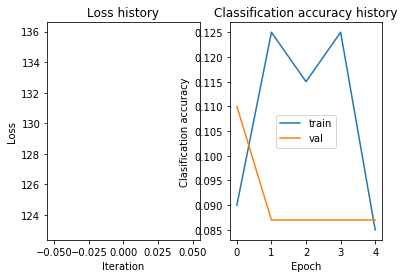

iteration [0 / 1000] : loss = 2.303147
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = inf
iteration [23 / 1000] : loss = inf
iteration [24 / 1000] : loss = inf
iteration [25 / 1000] : loss = inf
iteration [26 / 1000] : loss = inf
iteration [27 / 1000] : loss = inf
iteration [28 / 1000] : l

iteration [268 / 1000] : loss = nan
iteration [269 / 1000] : loss = nan
iteration [270 / 1000] : loss = nan
iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : loss = nan
iteration [280 / 1000] : loss = nan
iteration [281 / 1000] : loss = nan
iteration [282 / 1000] : loss = nan
iteration [283 / 1000] : loss = nan
iteration [284 / 1000] : loss = nan
iteration [285 / 1000] : loss = nan
iteration [286 / 1000] : loss = nan
iteration [287 / 1000] : loss = nan
iteration [288 / 1000] : loss = nan
iteration [289 / 1000] : loss = nan
iteration [290 / 1000] : loss = nan
iteration [291 / 1000] : loss = nan
iteration [292 / 1000] : loss = nan
iteration [293 / 1000] : loss = nan
iteration [294 / 1000] : loss = nan
iteration [295 / 1000] : los

iteration [497 / 1000] : loss = nan
iteration [498 / 1000] : loss = nan
iteration [499 / 1000] : loss = nan
iteration [500 / 1000] : loss = nan
iteration [501 / 1000] : loss = nan
iteration [502 / 1000] : loss = nan
iteration [503 / 1000] : loss = nan
iteration [504 / 1000] : loss = nan
iteration [505 / 1000] : loss = nan
iteration [506 / 1000] : loss = nan
iteration [507 / 1000] : loss = nan
iteration [508 / 1000] : loss = nan
iteration [509 / 1000] : loss = nan
iteration [510 / 1000] : loss = nan
iteration [511 / 1000] : loss = nan
iteration [512 / 1000] : loss = nan
iteration [513 / 1000] : loss = nan
iteration [514 / 1000] : loss = nan
iteration [515 / 1000] : loss = nan
iteration [516 / 1000] : loss = nan
iteration [517 / 1000] : loss = nan
iteration [518 / 1000] : loss = nan
iteration [519 / 1000] : loss = nan
iteration [520 / 1000] : loss = nan
iteration [521 / 1000] : loss = nan
iteration [522 / 1000] : loss = nan
iteration [523 / 1000] : loss = nan
iteration [524 / 1000] : los

iteration [730 / 1000] : loss = nan
iteration [731 / 1000] : loss = nan
iteration [732 / 1000] : loss = nan
iteration [733 / 1000] : loss = nan
iteration [734 / 1000] : loss = nan
iteration [735 / 1000] : loss = nan
iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : loss = nan
iteration [749 / 1000] : loss = nan
iteration [750 / 1000] : loss = nan
iteration [751 / 1000] : loss = nan
iteration [752 / 1000] : loss = nan
iteration [753 / 1000] : loss = nan
iteration [754 / 1000] : loss = nan
iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : los

iteration [990 / 1000] : loss = nan
iteration [991 / 1000] : loss = nan
iteration [992 / 1000] : loss = nan
iteration [993 / 1000] : loss = nan
iteration [994 / 1000] : loss = nan
iteration [995 / 1000] : loss = nan
iteration [996 / 1000] : loss = nan
iteration [997 / 1000] : loss = nan
iteration [998 / 1000] : loss = nan
iteration [999 / 1000] : loss = nan


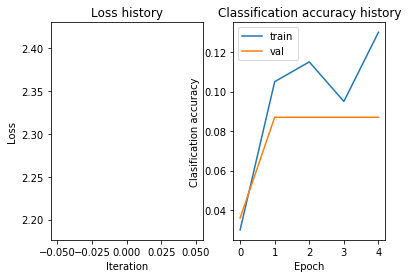

iteration [0 / 1000] : loss = 197.282248
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = nan
iteration [17 / 1000] : loss = nan
iteration [18 / 1000] : loss = nan
iteration [19 / 1000] : loss = nan
iteration [20 / 1000] : loss = nan
iteration [21 / 1000] : loss = nan
iteration [22 / 1000] : loss = nan
iteration [23 / 1000] : loss = nan
iteration [24 / 1000] : loss = nan
iteration [25 / 1000] : loss = nan
iteration [26 / 1000] : loss = nan
iteration [27 / 1000] : loss = nan
iteration [28 / 1000] :

iteration [264 / 1000] : loss = nan
iteration [265 / 1000] : loss = nan
iteration [266 / 1000] : loss = nan
iteration [267 / 1000] : loss = nan
iteration [268 / 1000] : loss = nan
iteration [269 / 1000] : loss = nan
iteration [270 / 1000] : loss = nan
iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : loss = nan
iteration [280 / 1000] : loss = nan
iteration [281 / 1000] : loss = nan
iteration [282 / 1000] : loss = nan
iteration [283 / 1000] : loss = nan
iteration [284 / 1000] : loss = nan
iteration [285 / 1000] : loss = nan
iteration [286 / 1000] : loss = nan
iteration [287 / 1000] : loss = nan
iteration [288 / 1000] : loss = nan
iteration [289 / 1000] : loss = nan
iteration [290 / 1000] : loss = nan
iteration [291 / 1000] : los

iteration [501 / 1000] : loss = nan
iteration [502 / 1000] : loss = nan
iteration [503 / 1000] : loss = nan
iteration [504 / 1000] : loss = nan
iteration [505 / 1000] : loss = nan
iteration [506 / 1000] : loss = nan
iteration [507 / 1000] : loss = nan
iteration [508 / 1000] : loss = nan
iteration [509 / 1000] : loss = nan
iteration [510 / 1000] : loss = nan
iteration [511 / 1000] : loss = nan
iteration [512 / 1000] : loss = nan
iteration [513 / 1000] : loss = nan
iteration [514 / 1000] : loss = nan
iteration [515 / 1000] : loss = nan
iteration [516 / 1000] : loss = nan
iteration [517 / 1000] : loss = nan
iteration [518 / 1000] : loss = nan
iteration [519 / 1000] : loss = nan
iteration [520 / 1000] : loss = nan
iteration [521 / 1000] : loss = nan
iteration [522 / 1000] : loss = nan
iteration [523 / 1000] : loss = nan
iteration [524 / 1000] : loss = nan
iteration [525 / 1000] : loss = nan
iteration [526 / 1000] : loss = nan
iteration [527 / 1000] : loss = nan
iteration [528 / 1000] : los

iteration [734 / 1000] : loss = nan
iteration [735 / 1000] : loss = nan
iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : loss = nan
iteration [749 / 1000] : loss = nan
iteration [750 / 1000] : loss = nan
iteration [751 / 1000] : loss = nan
iteration [752 / 1000] : loss = nan
iteration [753 / 1000] : loss = nan
iteration [754 / 1000] : loss = nan
iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : loss = nan
iteration [759 / 1000] : loss = nan
iteration [760 / 1000] : loss = nan
iteration [761 / 1000] : los

iteration [995 / 1000] : loss = nan
iteration [996 / 1000] : loss = nan
iteration [997 / 1000] : loss = nan
iteration [998 / 1000] : loss = nan
iteration [999 / 1000] : loss = nan


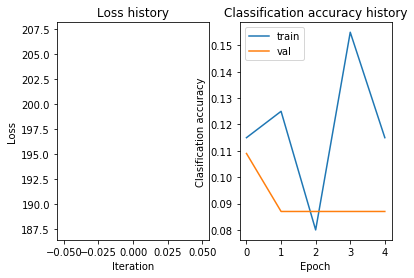

iteration [0 / 1000] : loss = 3.081717
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = nan
iteration [21 / 1000] : loss = nan
iteration [22 / 1000] : loss = nan
iteration [23 / 1000] : loss = nan
iteration [24 / 1000] : loss = nan
iteration [25 / 1000] : loss = nan
iteration [26 / 1000] : loss = nan
iteration [27 / 1000] : loss = nan
iteration [28 / 1000] : l

iteration [253 / 1000] : loss = nan
iteration [254 / 1000] : loss = nan
iteration [255 / 1000] : loss = nan
iteration [256 / 1000] : loss = nan
iteration [257 / 1000] : loss = nan
iteration [258 / 1000] : loss = nan
iteration [259 / 1000] : loss = nan
iteration [260 / 1000] : loss = nan
iteration [261 / 1000] : loss = nan
iteration [262 / 1000] : loss = nan
iteration [263 / 1000] : loss = nan
iteration [264 / 1000] : loss = nan
iteration [265 / 1000] : loss = nan
iteration [266 / 1000] : loss = nan
iteration [267 / 1000] : loss = nan
iteration [268 / 1000] : loss = nan
iteration [269 / 1000] : loss = nan
iteration [270 / 1000] : loss = nan
iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : loss = nan
iteration [280 / 1000] : los

iteration [481 / 1000] : loss = nan
iteration [482 / 1000] : loss = nan
iteration [483 / 1000] : loss = nan
iteration [484 / 1000] : loss = nan
iteration [485 / 1000] : loss = nan
iteration [486 / 1000] : loss = nan
iteration [487 / 1000] : loss = nan
iteration [488 / 1000] : loss = nan
iteration [489 / 1000] : loss = nan
iteration [490 / 1000] : loss = nan
iteration [491 / 1000] : loss = nan
iteration [492 / 1000] : loss = nan
iteration [493 / 1000] : loss = nan
iteration [494 / 1000] : loss = nan
iteration [495 / 1000] : loss = nan
iteration [496 / 1000] : loss = nan
iteration [497 / 1000] : loss = nan
iteration [498 / 1000] : loss = nan
iteration [499 / 1000] : loss = nan
iteration [500 / 1000] : loss = nan
iteration [501 / 1000] : loss = nan
iteration [502 / 1000] : loss = nan
iteration [503 / 1000] : loss = nan
iteration [504 / 1000] : loss = nan
iteration [505 / 1000] : loss = nan
iteration [506 / 1000] : loss = nan
iteration [507 / 1000] : loss = nan
iteration [508 / 1000] : los

iteration [717 / 1000] : loss = nan
iteration [718 / 1000] : loss = nan
iteration [719 / 1000] : loss = nan
iteration [720 / 1000] : loss = nan
iteration [721 / 1000] : loss = nan
iteration [722 / 1000] : loss = nan
iteration [723 / 1000] : loss = nan
iteration [724 / 1000] : loss = nan
iteration [725 / 1000] : loss = nan
iteration [726 / 1000] : loss = nan
iteration [727 / 1000] : loss = nan
iteration [728 / 1000] : loss = nan
iteration [729 / 1000] : loss = nan
iteration [730 / 1000] : loss = nan
iteration [731 / 1000] : loss = nan
iteration [732 / 1000] : loss = nan
iteration [733 / 1000] : loss = nan
iteration [734 / 1000] : loss = nan
iteration [735 / 1000] : loss = nan
iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : los

iteration [955 / 1000] : loss = nan
iteration [956 / 1000] : loss = nan
iteration [957 / 1000] : loss = nan
iteration [958 / 1000] : loss = nan
iteration [959 / 1000] : loss = nan
iteration [960 / 1000] : loss = nan
iteration [961 / 1000] : loss = nan
iteration [962 / 1000] : loss = nan
iteration [963 / 1000] : loss = nan
iteration [964 / 1000] : loss = nan
iteration [965 / 1000] : loss = nan
iteration [966 / 1000] : loss = nan
iteration [967 / 1000] : loss = nan
iteration [968 / 1000] : loss = nan
iteration [969 / 1000] : loss = nan
iteration [970 / 1000] : loss = nan
iteration [971 / 1000] : loss = nan
iteration [972 / 1000] : loss = nan
iteration [973 / 1000] : loss = nan
iteration [974 / 1000] : loss = nan
iteration [975 / 1000] : loss = nan
iteration [976 / 1000] : loss = nan
iteration [977 / 1000] : loss = nan
iteration [978 / 1000] : loss = nan
iteration [979 / 1000] : loss = nan
iteration [980 / 1000] : loss = nan
iteration [981 / 1000] : loss = nan
iteration [982 / 1000] : los

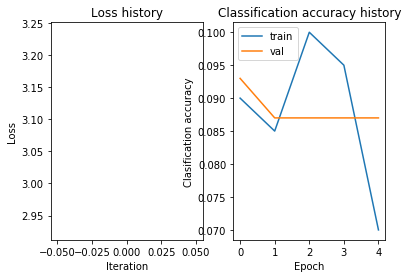

iteration [0 / 1000] : loss = 2.414415
iteration [1 / 1000] : loss = inf
iteration [2 / 1000] : loss = inf
iteration [3 / 1000] : loss = inf
iteration [4 / 1000] : loss = inf
iteration [5 / 1000] : loss = inf
iteration [6 / 1000] : loss = inf
iteration [7 / 1000] : loss = inf
iteration [8 / 1000] : loss = inf
iteration [9 / 1000] : loss = inf
iteration [10 / 1000] : loss = inf
iteration [11 / 1000] : loss = inf
iteration [12 / 1000] : loss = inf
iteration [13 / 1000] : loss = inf
iteration [14 / 1000] : loss = inf
iteration [15 / 1000] : loss = inf
iteration [16 / 1000] : loss = inf
iteration [17 / 1000] : loss = inf
iteration [18 / 1000] : loss = inf
iteration [19 / 1000] : loss = inf
iteration [20 / 1000] : loss = inf
iteration [21 / 1000] : loss = inf
iteration [22 / 1000] : loss = nan
iteration [23 / 1000] : loss = nan
iteration [24 / 1000] : loss = nan
iteration [25 / 1000] : loss = nan
iteration [26 / 1000] : loss = nan
iteration [27 / 1000] : loss = nan
iteration [28 / 1000] : l

iteration [257 / 1000] : loss = nan
iteration [258 / 1000] : loss = nan
iteration [259 / 1000] : loss = nan
iteration [260 / 1000] : loss = nan
iteration [261 / 1000] : loss = nan
iteration [262 / 1000] : loss = nan
iteration [263 / 1000] : loss = nan
iteration [264 / 1000] : loss = nan
iteration [265 / 1000] : loss = nan
iteration [266 / 1000] : loss = nan
iteration [267 / 1000] : loss = nan
iteration [268 / 1000] : loss = nan
iteration [269 / 1000] : loss = nan
iteration [270 / 1000] : loss = nan
iteration [271 / 1000] : loss = nan
iteration [272 / 1000] : loss = nan
iteration [273 / 1000] : loss = nan
iteration [274 / 1000] : loss = nan
iteration [275 / 1000] : loss = nan
iteration [276 / 1000] : loss = nan
iteration [277 / 1000] : loss = nan
iteration [278 / 1000] : loss = nan
iteration [279 / 1000] : loss = nan
iteration [280 / 1000] : loss = nan
iteration [281 / 1000] : loss = nan
iteration [282 / 1000] : loss = nan
iteration [283 / 1000] : loss = nan
iteration [284 / 1000] : los

iteration [502 / 1000] : loss = nan
iteration [503 / 1000] : loss = nan
iteration [504 / 1000] : loss = nan
iteration [505 / 1000] : loss = nan
iteration [506 / 1000] : loss = nan
iteration [507 / 1000] : loss = nan
iteration [508 / 1000] : loss = nan
iteration [509 / 1000] : loss = nan
iteration [510 / 1000] : loss = nan
iteration [511 / 1000] : loss = nan
iteration [512 / 1000] : loss = nan
iteration [513 / 1000] : loss = nan
iteration [514 / 1000] : loss = nan
iteration [515 / 1000] : loss = nan
iteration [516 / 1000] : loss = nan
iteration [517 / 1000] : loss = nan
iteration [518 / 1000] : loss = nan
iteration [519 / 1000] : loss = nan
iteration [520 / 1000] : loss = nan
iteration [521 / 1000] : loss = nan
iteration [522 / 1000] : loss = nan
iteration [523 / 1000] : loss = nan
iteration [524 / 1000] : loss = nan
iteration [525 / 1000] : loss = nan
iteration [526 / 1000] : loss = nan
iteration [527 / 1000] : loss = nan
iteration [528 / 1000] : loss = nan
iteration [529 / 1000] : los

iteration [732 / 1000] : loss = nan
iteration [733 / 1000] : loss = nan
iteration [734 / 1000] : loss = nan
iteration [735 / 1000] : loss = nan
iteration [736 / 1000] : loss = nan
iteration [737 / 1000] : loss = nan
iteration [738 / 1000] : loss = nan
iteration [739 / 1000] : loss = nan
iteration [740 / 1000] : loss = nan
iteration [741 / 1000] : loss = nan
iteration [742 / 1000] : loss = nan
iteration [743 / 1000] : loss = nan
iteration [744 / 1000] : loss = nan
iteration [745 / 1000] : loss = nan
iteration [746 / 1000] : loss = nan
iteration [747 / 1000] : loss = nan
iteration [748 / 1000] : loss = nan
iteration [749 / 1000] : loss = nan
iteration [750 / 1000] : loss = nan
iteration [751 / 1000] : loss = nan
iteration [752 / 1000] : loss = nan
iteration [753 / 1000] : loss = nan
iteration [754 / 1000] : loss = nan
iteration [755 / 1000] : loss = nan
iteration [756 / 1000] : loss = nan
iteration [757 / 1000] : loss = nan
iteration [758 / 1000] : loss = nan
iteration [759 / 1000] : los

iteration [988 / 1000] : loss = nan
iteration [989 / 1000] : loss = nan
iteration [990 / 1000] : loss = nan
iteration [991 / 1000] : loss = nan
iteration [992 / 1000] : loss = nan
iteration [993 / 1000] : loss = nan
iteration [994 / 1000] : loss = nan
iteration [995 / 1000] : loss = nan
iteration [996 / 1000] : loss = nan
iteration [997 / 1000] : loss = nan
iteration [998 / 1000] : loss = nan
iteration [999 / 1000] : loss = nan


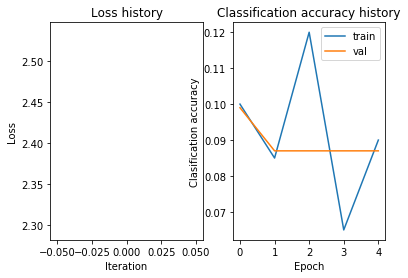

TRAINING procedure OVER..............
STOP.
...............RESULTS.....................
h1_size: 500    lr: 23.371949    reg: 0.681945    val_acc = 0.087000
h1_size: 500    lr: 0.438974    reg: 236561.473249    val_acc = 0.087000
h1_size: 500    lr: 142.529038    reg: 135.645736    val_acc = 0.087000
h1_size: 500    lr: 57652.881845    reg: 155013.204930    val_acc = 0.087000
h1_size: 500    lr: 0.522056    reg: 155013.204930    val_acc = 0.087000
h1_size: 500    lr: 142.529038    reg: 236561.473249    val_acc = 0.087000
h1_size: 500    lr: 23.371949    reg: 957.879898    val_acc = 0.087000
h1_size: 500    lr: 0.438974    reg: 155013.204930    val_acc = 0.087000
h1_size: 500    lr: 142.529038    reg: 957.879898    val_acc = 0.087000
h1_size: 500    lr: 57652.881845    reg: 236561.473249    val_acc = 0.087000
h1_size: 500    lr: 0.522056    reg: 957.879898    val_acc = 0.087000
h1_size: 500    lr: 23.371949    reg: 135.645736    val_acc = 0.087000
h1_size: 500    lr: 23.371949    reg: 2

In [16]:
from modules.classifiers.neural_net import TwoLayerNet
from modules.classifiers.tune_hyperparams import tune_hyperparams

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

best_net = tune_hyperparams(X=X_train_feats, y=y_train, X_val=X_val_feats, y_val=y_val, 
                            input_size=input_dim, num_train_epochs=5, 
                            h1_size_array=[hidden_dim], verbose=True)
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [15]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.131
